## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

['../camera_cal/calibration1.jpg', '../camera_cal/calibration10.jpg', '../camera_cal/calibration11.jpg', '../camera_cal/calibration12.jpg', '../camera_cal/calibration13.jpg', '../camera_cal/calibration14.jpg', '../camera_cal/calibration15.jpg', '../camera_cal/calibration16.jpg', '../camera_cal/calibration17.jpg', '../camera_cal/calibration18.jpg', '../camera_cal/calibration19.jpg', '../camera_cal/calibration2.jpg', '../camera_cal/calibration20.jpg', '../camera_cal/calibration3.jpg', '../camera_cal/calibration4.jpg', '../camera_cal/calibration5.jpg', '../camera_cal/calibration6.jpg', '../camera_cal/calibration7.jpg', '../camera_cal/calibration8.jpg', '../camera_cal/calibration9.jpg']


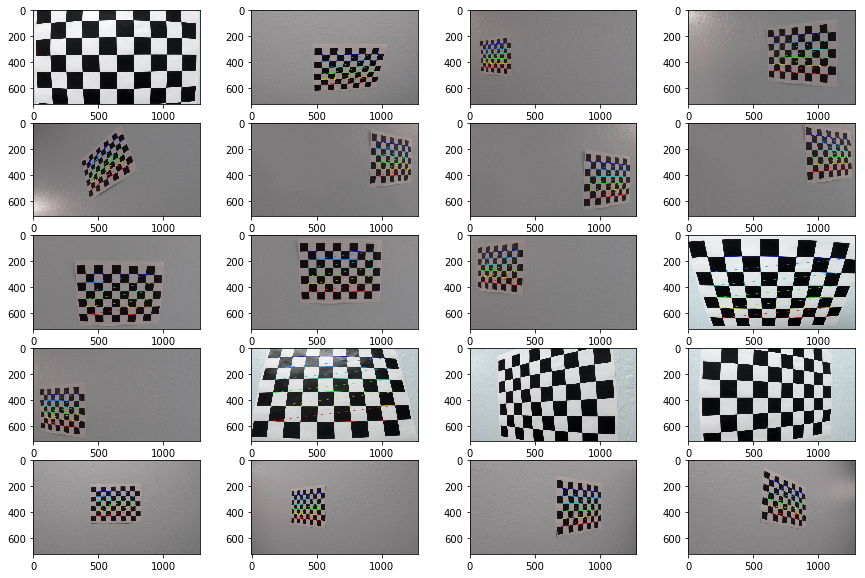

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from os import listdir

%matplotlib inline 

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.


# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
print(images)
#set imgs size
fig = plt.figure(figsize=(15, 10))


#loop all imgs
for num, fname in enumerate(images):
    img = cv2.imread(fname) #read in img
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #grayscale
    ret, corners = cv2.findChessboardCorners(gray_img, (9, 6), None) #find chessboard corners
    #if corners found, get objpoints, imgpoints
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        cv2.drawChessboardCorners(img, (9, 6), corners, ret) #draw chessboard corners 
    #show all imgs
    fig.add_subplot(5, 4, (num+1))
    plt.imshow(img)   

global objpoints
global imgpoints
plt.show()


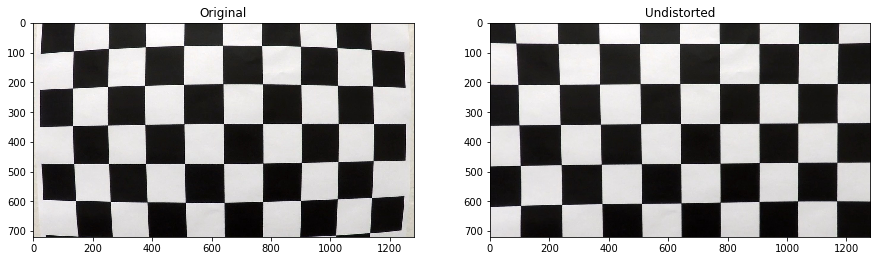

In [2]:
#creat undistort function 

imgs = glob.glob('../test_images/*.jpg')
the_gray = cv2.cvtColor(cv2.imread(imgs[0]), cv2.COLOR_BGR2GRAY)

_, _mtx, _dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, the_gray.shape[::-1], None, None)


def undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    undist = cv2.undistort(img, _mtx, _dist, None, _mtx)
    return undist



#see chessboard test result 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 10))

chess_img = plt.imread(images[0])
chess_undist= undistort(chess_img, objpoints, imgpoints)
ax1.imshow(chess_img)
ax1.set_title('Original')
ax2.imshow(chess_undist)
ax2.set_title('Undistorted')



# example of a distortion-corrected image

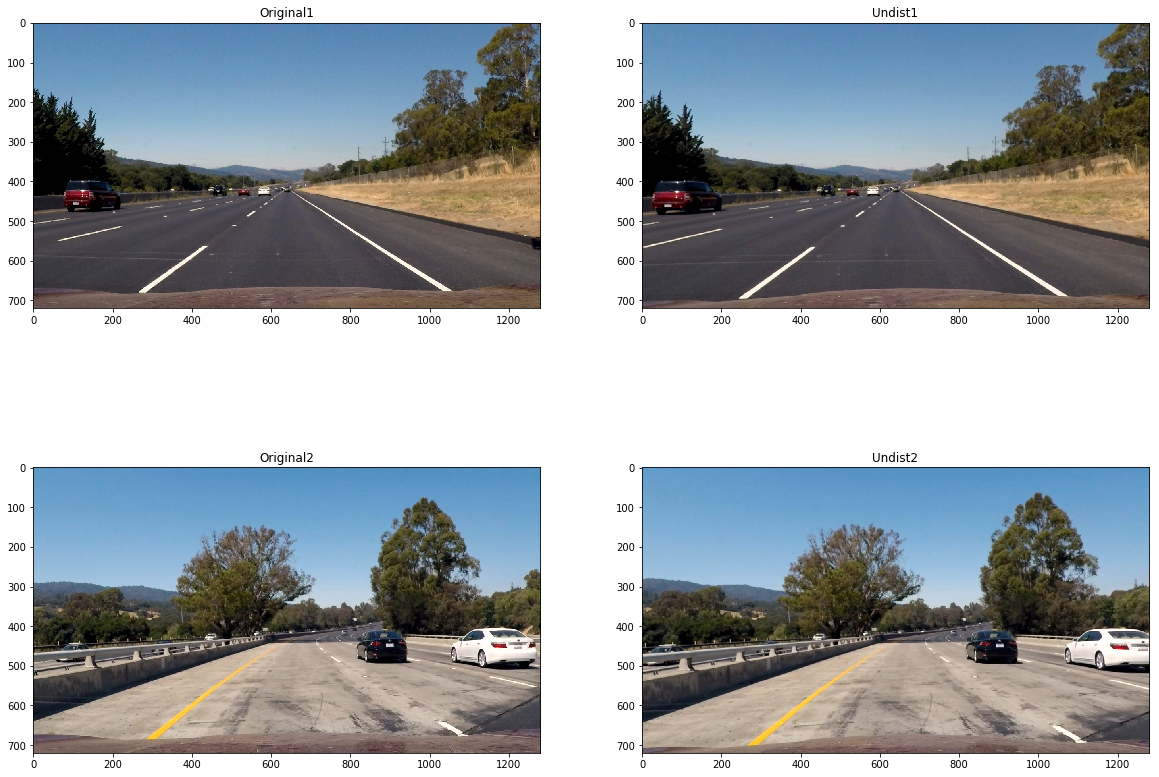

In [3]:
plt.figure(figsize=(20, 15))
#read in road_test_imgs
test_road_imgs = glob.glob('../test_images/*.jpg')
read_test_imgs = []
for img in test_road_imgs:
    read_test_imgs.append(plt.imread(img))

#Examples shown below
test_img1 = read_test_imgs[1]
undist1= undistort(test_img1, objpoints, imgpoints)

test_img2 = read_test_imgs[2]
undist2= undistort(test_img2, objpoints, imgpoints)

test_img3 = read_test_imgs[3]
undist3 = undistort(test_img3, objpoints, imgpoints)
 
plt.subplot(2, 2, 1)
plt.title('Original1')
plt.imshow(test_img1)

plt.subplot(2, 2, 2)
plt.title('Undist1')
plt.imshow(undist1)

plt.subplot(2, 2, 3)
plt.title('Original2')
plt.imshow(test_img2)

plt.subplot(2, 2, 4)
plt.title('Undist2')
plt.imshow(undist2)



# # Perspective Transform

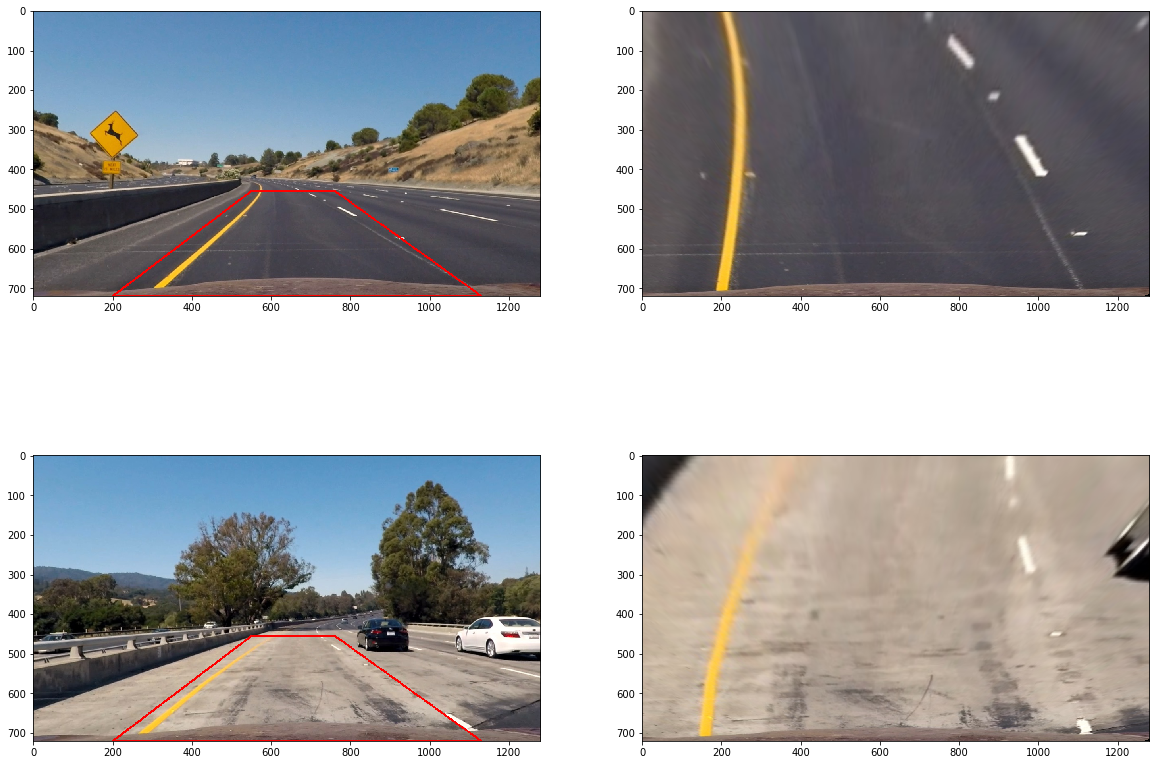

In [27]:
# create a warped function and return a warped_img 
def bird_eye_view(undist_img, dst, src):
    img_size = undist_img.shape[1::-1]
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped_img = cv2.warpPerspective(undist_img, M, img_size)
    return warped_img, M, Minv

#creat a mask_area function and return the specific area targeted
def mask_area(undist_img):
    #make copy of img
    copy_undist= undist_img.copy()
    
    #use previous un-disotrted img
    #get undist w and h
    undist_shape = undist_img.shape[1::-1]
    
    #left_top and right_top has same y, same for the left_bottom and right_bottom 
    top_y = 455
    bottom_y = undist_shape[1] #720
    
    #get every corner points also get seperated x and y
    left_down = (200, bottom_y)
    left_down_x, left_down_y = left_down
    
    left_top = (550, top_y)
    left_top_x, left_top_y = left_top 
    
    right_top = (undist_shape[0]-520, top_y)
    right_top_x, right_top_y = right_top
    
    right_down = (undist_shape[0]-150, bottom_y)
    right_down_x, right_down_y = right_down
    
    #draw target area
    color = [255, 0, 0]
    cv2.line(copy_undist, left_down, left_top, color, 4)
    cv2.line(copy_undist, left_down, right_down, color, 4)
    cv2.line(copy_undist, left_top, right_top, color, 4)
    cv2.line(copy_undist, right_top, right_down , color, 4)
    
    #src points
    src = np.float32([[left_down_x, left_down_y],  #left_down 
                      [left_top_x, left_top_y],  #left_top
                      [right_top_x, right_top_y],  #right_top
                      [right_down_x, right_down_y]])#right_down
    
    #dst points
    dst = np.float32([[100, undist_shape[1]], #left_down
                      [100, 0], #left_top
                      [1100, 0], #right_top
                      [1100, undist_shape[1]]]) #right_down
    return copy_undist, src, dst 

copy_undist2, src, dst = mask_area(undist2)
copy_undist3, _, _ = mask_area(undist3)
undist_warped2, M, Minv = bird_eye_view(undist2, dst, src)
undist_warped3, _, _= bird_eye_view(undist3, dst, src)

global src
global dst
 
#Example shown below 
plt.figure(figsize =(20, 15))
plt.subplot(2, 2, 1)
plt.imshow(copy_undist3)

plt.subplot(2, 2, 2)
plt.imshow(undist_warped3)

plt.subplot(2, 2, 3)
plt.imshow(copy_undist2)

plt.subplot(2, 2, 4)
plt.imshow(undist_warped2)


# Color and Gradient Threshold 

In [5]:


# L channel from LUV with lower and upper thresholds around 225 & 255
def luv_binary(img, thresh):
    luv = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    #get only s here
    l = luv[:,:,0]
    color_binary = np.zeros_like(l)
    color_binary[(l >= thresh[0]) & (l <= thresh[1])]=1
    return color_binary
    
# b channel from Lab which does a great job with the yellow lines
# (you can play around with thresholds around 155 & 200)

    
# create a function -- threshold_xbinary
def threshold_xbinary(img, orient, sobel_kernel, thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #default orient=='x' 
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])]= 1
    return sxbinary

def b_binary(img, thresh):
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    b = img[:,:,2]
    bbinary = np.zeros_like(b)
    bbinary[(b >= thresh[0]) & (b <= thresh[1])] =1 
    return bbinary 

def hls_binary(img, thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #get only s here
    s = hls[:,:,2]
    color_binary = np.zeros_like(s)
    color_binary[(s >= thresh[0]) & (s <= thresh[1])]=1
    return color_binary
    
    
def mag_binary(img, sobel_kernel, thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx= cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    magnitude_xy = np.sqrt(sobelx**2 + sobely**2)
    scaled_xy= np.uint8(255*magnitude_xy/np.max(magnitude_xy))
    magnitude_binary = np.zeros_like(magnitude_xy)
    magnitude_binary[(scaled_xy >= thresh[0]) & (scaled_xy <= thresh[1])] =1
    return magnitude_binary 


def dir_binary(img, sobel_kernel, thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    arc = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(arc)
    dir_binary[(arc >= thresh[0]) & (arc <= thresh[1])] = 1
    return dir_binary 


def sobel_combined(image):
    # Apply combined sobel filter
    image = cv2.GaussianBlur(image, (5, 5), 0)
    img_g_mag = mag_binary(image,3,(20,150))
    img_d_mag = dir_binary(image,3,(.6,1.1))
    img_abs_x = threshold_xbinary(image,'x',5,(50,200))
    img_abs_y = threshold_xbinary(image,'y',5,(50,200))
    sobel_combined = np.zeros_like(img_d_mag)
    sobel_combined[((img_abs_x == 1) & (img_abs_y == 1)) | \
               ((img_g_mag == 1) & (img_d_mag == 1))] = 1
    return sobel_combined


def combined_v1(image):
    # Apply combined sobel filter
    image = cv2.GaussianBlur(image, (5, 5), 0)
    luv = luv_binary(image, thresh=(225, 255))
    bbinary = b_binary(image, thresh=(155, 200))
    
    combined_binary = np.zeros_like(image)
    combined_binary[(luv==1) | (bbinary==1)]=1
    return combined_binary



def combined_binary(img, threshold_xbinary, sbinary):
    color_binary = np.dstack((np.zeros_like(threshold_xbinary), threshold_xbinary, sbinary))*255
    combined_binary = np.zeros_like(threshold_xbinary)
    combined_binary[(threshold_xbinary==1) | (sbinary==1)]=1
    return combined_binary


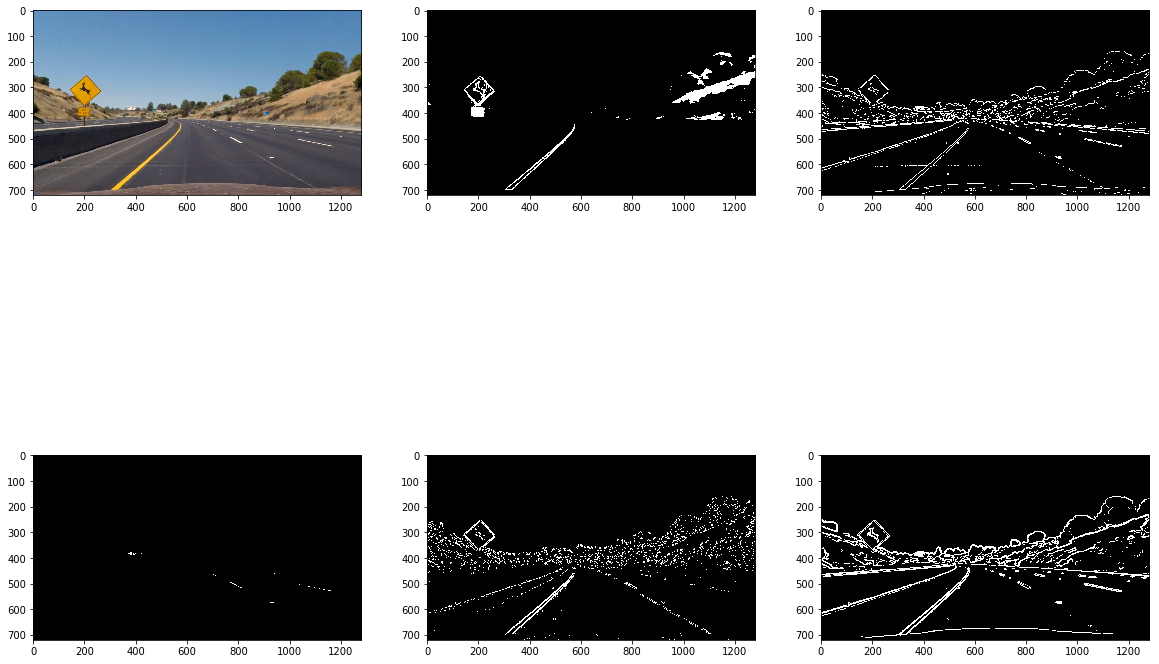

In [6]:
luv = luv_binary(undist3, thresh=(225, 255))

hls = hls_binary(undist3, thresh=(100, 255))

bbinary = b_binary(undist3, thresh=(155, 200))


sybinary = threshold_xbinary(undist3, orient ='y', sobel_kernel =3, thresh = (30, 200))
dirbinary = dir_binary(undist3, sobel_kernel =3, thresh=(0.9, np.pi/2))
mag = mag_binary(undist3, sobel_kernel = 15, thresh = (50, 200))
sobel_comb = sobel_combined(undist3)

fig = plt.figure(figsize =(20, 15))
#1
ax1 = fig.add_subplot(2, 3, 1)
ax1.imshow(undist3)
#2
ax2 = fig.add_subplot(2, 3, 2)
ax2.imshow(bbinary, cmap='gray')
#3
ax3 = fig.add_subplot(2, 3, 3)
ax3.imshow(sybinary, cmap='gray')
#4
ax4 = fig.add_subplot(2, 3, 4)
ax4.imshow(luv, cmap='gray')
#5
ax5 = fig.add_subplot(2, 3, 5)
ax5.imshow(sobel_comb, cmap='gray')
#6
ax6 = fig.add_subplot(2, 3, 6)
ax6.imshow(mag, cmap='gray')

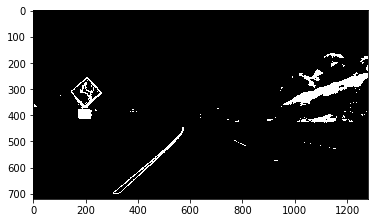

In [7]:
#binary_combo_example
combined1 = combined_binary(undist3, hls, sobel_comb)
combined2 = combined_binary(undist3, luv, bbinary)

plt.imshow(combined1, cmap = 'gray')
plt.imshow(combined2, cmap = 'gray')



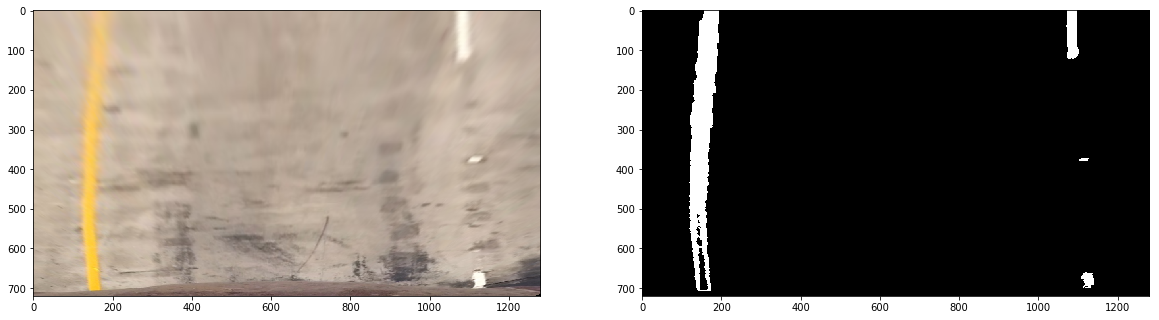

In [8]:
#apply combination to bird eye view
def binary_warped(undist_img):
    warped_img, _, _ = bird_eye_view(undist_img, dst, src)
    hls = hls_binary(warped_img, thresh=(100, 255))
    sobel_comb = sobel_combined(warped_img)
    binary_warped_img = combined_binary(warped_img, hls, sobel_comb)
    return binary_warped_img


#apply combination to bird eye view
def binary_warped(undist_img):
    warped_img, _, _ = bird_eye_view(undist_img, dst, src)
    
    luv = luv_binary(warped_img, thresh=(225, 255))
    bbinary = b_binary(warped_img, thresh=(155, 200))

    
    binary_warped_img = combined_binary(warped_img, luv, bbinary)
    return binary_warped_img


binary_warped2 = binary_warped(undist2)
fig, (ax1, ax2) = plt.subplots(1, 2 , figsize =(20, 15))
ax1.imshow(undist_warped2)
ax2.imshow(binary_warped2, cmap='gray')

# Lane Line Detection

640


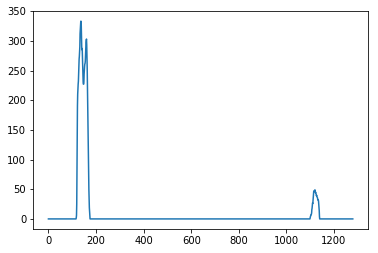

In [9]:
#find midpoint of two lane lines
histogram = np.sum(binary_warped2[binary_warped2.shape[0]//2:,:], axis = 0)
midpoint = np.int(histogram.shape[0]//2)
print(midpoint)
plt.plot(histogram)

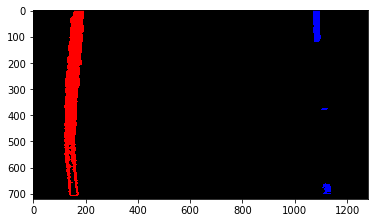

In [10]:
def lane_finding(warped_img):
    histogram = np.sum(warped_img[warped_img.shape[0]//2:,:], axis = 0)
    midpoint = np.int(histogram.shape[0]//2)
    left_xbase = np.argmax(histogram[:midpoint])
    right_xbase = np.argmax(histogram[midpoint:]) +midpoint
    out_img = np.dstack((warped_img, warped_img, warped_img))*255

    nwindows = 9
    window_height = np.int(warped_img.shape[0]//nwindows)
    
    nonzero = warped_img.nonzero()
    nonzerox = nonzero[1]
    nonzeroy = nonzero[0]

    left_xcurrent = left_xbase
    right_xcurrent = right_xbase
    
    margin = 90
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_ylow = warped_img.shape[0]-(window+1)*window_height
        win_yhigh = warped_img.shape[0]-window*window_height
        win_xleft_low = left_xcurrent - margin
        win_xleft_high = left_xcurrent + margin
        win_xright_low = right_xcurrent - margin
        win_xright_high = right_xcurrent + margin
        
        #cv2.rectangle(out_img, (win_xleft_low, win_ylow), (win_xleft_high, win_yhigh), (0, 255, 0), 2)
        #cv2.rectangle(out_img, (win_xright_low, win_ylow), (win_xright_high, win_yhigh), (0, 255, 0), 2)
        
        good_left_inds = ((nonzeroy >= win_ylow) & (nonzeroy < win_yhigh) & (nonzerox >= win_xleft_low)
                          & (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_ylow) & (nonzeroy < win_yhigh) & (nonzerox >= win_xright_low) 
                           & (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            left_xcurrent = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            right_xcurrent = np.int(np.mean(nonzerox[good_right_inds]))
    
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    #extract the inds    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    #fit left/right to the second polynomial
    if len(leftx) == 0:
        left_fit = []
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) == []:
        right_fit = []
    else:
        right_fit = np.polyfit(righty, rightx, 2)
        
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    return out_img, left_fit, right_fit, left_lane_inds, right_lane_inds

out_img, left_fit, right_fit, left_lane_inds, right_lane_inds= lane_finding(binary_warped2)

#visualize color fit line 
plt.imshow(out_img)

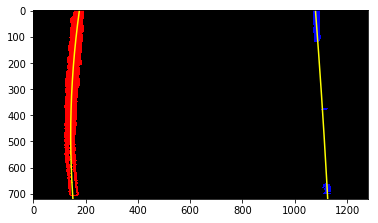

In [11]:
#draw yellow line 
ploty = np.linspace(0, binary_warped2.shape[0]-1, binary_warped2.shape[0]) 
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
plt.plot(left_fitx, ploty, color = 'yellow')
plt.plot(right_fitx, ploty, color = 'yellow')
plt.imshow(out_img)

In [12]:
def next_frame_finding(next_warped_img, left_fit, right_fit):
    #get nonzero
    nonzero = next_warped_img.nonzero()
    nonzerox = nonzero[1]
    nonzeroy = nonzero[0]
    
    margin = 100
    #create a img to draw 
   
    out_img = np.dstack((next_warped_img, next_warped_img, next_warped_img))*255
    #window_img = np.zeros_like(out_img)
    
    left_lane_inds = ((nonzerox > (left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2]-margin)) & 
                      (nonzerox < (left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy +left_fit[2] +margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] - margin)) &
                      (nonzerox < (right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] +margin)))
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx)==0:
        continue_left_fit = []
    else:
        continue_left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) == 0:
        continue_right_fit = []
    else:
        continue_right_fit = np.polyfit(righty, rightx, 2)
    return continue_left_fit, continue_right_fit, left_lane_inds, right_lane_inds

In [13]:



def curvature(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    y_eval = np.max(ploty)
    nonzero = binary_warped.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # A conversion of xm_per_pix = 3.7/700 assumes that the lane is only 700 pixels wide in the birds eye view images,
    # but in your example warped images the lane appears to be quite a bit wider than 700 pixels,
    # so you should replace the 700 with the actual width of the lane.

    # You should make a similar adjustment for ym_per_pix by replace the 30 with the 
    # length of road that is visible in front of the car in the birds eye view images.
    # You can do your best to estimate this by assuming that each long white dash is about 3 meters long

    print(binary_warped.shape[0])
    
    ym_per_pix = 20 / 230  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 920 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    left_curve = ((1+(2*left_fit_cr[0]*y_eval*ym_per_pix+left_fit_cr[1])**2)**1.5)/np.abs(2*left_fit_cr[0])
    right_curve = ((1+(2*right_fit_cr[0]*y_eval*ym_per_pix+right_fit_cr[1])**2)**1.5)/np.abs(2*right_fit_cr[0])
    
    #car position in the middle of img
    car_position = binary_warped.shape[1]/2
    #calculate left and right bottom, center curvature is half of the sum
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[1]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[1]*y_eval + right_fit[2]
    center_position = (left_lane_bottom + right_lane_bottom) /2.
    center_locate = (car_position-center_position)*xm_per_pix
    return center_locate, left_curve, right_curve

#example
center_location, left_curve, right_curve= curvature(binary_warped2, left_fit, right_fit, left_lane_inds, right_lane_inds)
print(center_location, left_curve, right_curve)

720
0.138628841693 6466.67141796 56757.2050555


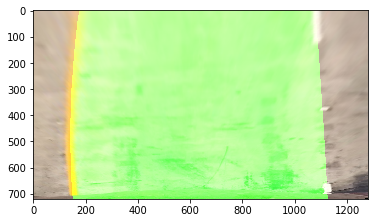

In [14]:
def path_visualize(undist_img, binary_warped, left_fit, right_fit):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)

    ploty = np.linspace (0, binary_warped.shape[0]-1, binary_warped.shape[0])
    #parabolas
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx =right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_line_window = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_window = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    line_pts = np.hstack((left_line_window, right_line_window))
    
    cv2.fillPoly(window_img, np.int_([line_pts]), (0, 255, 0))
    result = cv2.addWeighted(undist_img, 1 , window_img, 0.7, 0) 
    return result
next_left_fit, next_right_fit, next_left_inds, next_right_inds = next_frame_finding(undist_warped2, left_fit, right_fit)
res = path_visualize(undist_warped2, binary_warped2, next_left_fit, next_right_fit)
plt.imshow(res)

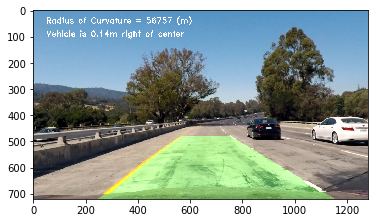

In [15]:
#draw and warp back to original image
def draw_back_original(binary_warped, undist, left_fitx, right_fitx, to_center, left_curve, right_curve):
    #create a blank img
    warped_zero = np.zeros_like(binary_warped).astype(np.uint8)
    #create a color img
    color_out = np.dstack((warped_zero, warped_zero, warped_zero))
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_out, np.int_([pts]), (0, 255, 0))
    
    #warped back to original undist img
    newwarp = cv2.warpPerspective(color_out, Minv, (undist.shape[1], undist.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    #get direction to left or right
    if to_center < 0:
        position = 'left'
        curvature = left_curve
    else:
        position = 'right'
        curvature = right_curve
    #visualize in warped back img 
    cv2.putText(result, 'Radius of Curvature = {:.0f} (m)'.format(curvature), (50, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, 'Vehicle is {:.2f}m {} of center'.format(to_center, position), (50, 100), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    return result

#example
result = draw_back_original(binary_warped2, undist2, left_fitx, right_fitx, center_location, left_curve, right_curve)
plt.imshow(result)

In [16]:
class Lane():
    def __init__(self):
        self.last_left = None
        self.last_right = None
        self.left_fit = None
        self.right_fit = None
        self.counter = 0
        
def check_slope(left_fit, right_fit):
    if len(left_fit)==0 or len(right_fit)== 0:
        status = False
    else:
        left_slope1 = 2*left_fit[0]*720 + left_fit[1]
        right_slope1 = 2*right_fit[0]*720 + right_fit[1]
        diff1 = np.abs(left_slope1 - right_slope1)
        
        left_slope2 = 2*left_fit[0]*360 + left_fit[1]
        right_slope2 = 2*right_fit[0]*360 + right_fit[1]
        diff2 = np.abs(left_slope2 - right_slope2)
        
        if diff1 <= 0.55 and diff2 <= 0.55:
            status = True
        else:
            status = False
        
    return status
        

In [17]:
lane = Lane()

def process_img(img):
    undist_img = undistort(img, objpoints, imgpoints)
    binary_warped_img = binary_warped(undist_img) 
    
    if lane.counter == 0:
        out_img, lane.left_fit, lane.right_fit, left_lane_inds, right_lane_inds = lane_finding(binary_warped_img)
    else:
        lane.left_fit, lane.right_fit, left_lane_inds, right_lane_inds = next_frame_finding(binary_warped_img, lane.left_fit, lane.right_fit)
    
    print(lane.left_fit)
    print(lane.last_left)
    print(lane.right_fit)

    
    status = check_slope(lane.left_fit, lane.right_fit)
    if status == True: 
        lane.last_left, lane.last_right = lane.left_fit, lane.right_fit
        lane.counter += 1
    else:
        lane.left_fit, lane.right_fit = lane.last_left, lane.last_right
        
    print(lane.left_fit)
    print(lane.last_left)
    print(lane.right_fit)
    
    ploty = np.linspace(0, binary_warped_img.shape[0]-1, binary_warped_img.shape[0]) 
    left_fitx = lane.left_fit[0]*ploty**2 + lane.left_fit[1]*ploty + lane.left_fit[2]
    right_fitx = lane.right_fit[0]*ploty**2 + lane.right_fit[1]*ploty + lane.right_fit[2]
     
    center_location, left_curve, right_curve = curvature(binary_warped_img, lane.left_fit, lane.right_fit, left_lane_inds, right_lane_inds)
    result = draw_back_original(binary_warped_img, undist_img,left_fitx, right_fitx, center_location, left_curve, right_curve)       
    return result 

[  3.13890029e-05  -9.25374046e-03   1.11187591e+02]
None
[  1.63723977e-05   1.13467202e-01   9.85267029e+02]
[  3.13890029e-05  -9.25374046e-03   1.11187591e+02]
[  3.13890029e-05  -9.25374046e-03   1.11187591e+02]
[  1.63723977e-05   1.13467202e-01   9.85267029e+02]
720


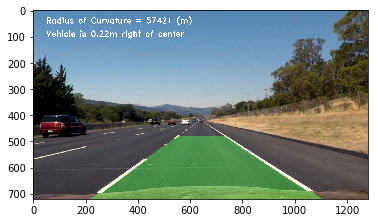

In [18]:
res = process_img(read_test_imgs[1])
plt.imshow(res)

In [19]:

from moviepy.editor import VideoFileClip
from IPython.display import HTML



In [ ]:
output = 'road.mp4'

from moviepy.editor import ImageSequenceClip
clip1 = VideoFileClip('../project_video.mp4')
new_frames = []


    
# %time new_frames = [process_img(fr) for fr in clip1.iter_frames()]
print('processing')
new_clip = clip1.fl_image(process_img)

print('images done processing')
    
    
# new_clip = ImageSequenceClip(new_frames, fps=cli/p1.fps)
%time new_clip.write_videofile(output, audio=False)
    

HTML("""
<video width="960" height="540" controls>
  <source src='{0}'>
</video>
""".format(output))

processing
[ -3.12731518e-04   1.75055297e-01   2.19769566e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  9.40094178e-05   2.49942466e-01   9.22334965e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -1.55960044e-05   1.70113985e-01   1.08702929e+03]
720
images done processing
[MoviePy] >>>> Building video road.mp4
[MoviePy] Writing video road.mp4



  0%|          | 1/1261 [00:00<02:30,  8.36it/s]

[ -3.12731518e-04   1.75055297e-01   2.19769566e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  9.40094178e-05   2.49942466e-01   9.22334965e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -1.55960044e-05   1.70113985e-01   1.08702929e+03]
720



  0%|          | 2/1261 [00:00<02:40,  7.85it/s]

[ -3.28765162e-04   1.90115610e-01   2.17882869e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  1.24185706e-03  -9.47355419e-01   1.23317543e+03]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -1.55960044e-05   1.70113985e-01   1.08702929e+03]
720


[ -3.35989976e-04   1.98644708e-01   2.16662659e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  7.57393756e-04  -3.90447240e-01   1.07271279e+03]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -1.55960044e-05   1.70113985e-01   1.08702929e+03]
720



  0%|          | 4/1261 [00:00<02:57,  7.08it/s]

[ -3.36833164e-04   2.02854630e-01   2.15811480e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -4.96871305e-05   5.93089021e-01   7.73285967e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -1.55960044e-05   1.70113985e-01   1.08702929e+03]
720



  0%|          | 5/1261 [00:00<03:23,  6.17it/s]

[ -3.58750148e-04   2.18939377e-01   2.13502882e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -5.72073168e-04   1.27935798e+00   5.48377673e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -1.55960044e-05   1.70113985e-01   1.08702929e+03]
720
[ -3.59607209e-04   2.26481608e-01   2.11451074e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -9.79665740e-04   1.84836400e+00   3.49094842e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -1.55960044e-05   1.70113985e-01   1.08702929e+03]


  0%|          | 6/1261 [00:01<03:52,  5.39it/s]


720
[ -3.42060758e-04   2.19477468e-01   2.10248663e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -2.55342919e-03   4.01247223e+00  -3.94851271e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -1.55960044e-05   1.70113985e-01   1.08702929e+03]
720



  1%|          | 9/1261 [00:01<03:03,  6.82it/s]

[ -3.40085986e-04   2.24174738e-01   2.09207317e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -1.12799347e-01   1.16903810e+02  -2.92133002e+04]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -1.55960044e-05   1.70113985e-01   1.08702929e+03]
720
[ -3.33854450e-04   2.23373312e-01   2.06235459e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -5.71853712e-02   6.26669396e+01  -1.60777218e+04]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -1.55960044e-05   1.70113985e-01   1.08702929e+03]
720



  1%|          | 11/1261 [00:01<02:51,  7.27it/s]

[ -3.28091554e-04   2.22302250e-01   2.04090486e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  2.74134501e-03  -4.04669860e+00   2.54324433e+03]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -1.55960044e-05   1.70113985e-01   1.08702929e+03]
720
[ -3.20470055e-04   2.20421240e-01   2.03171565e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  2.02250692e-02  -2.61232681e+01   9.56166063e+03]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -1.55960044e-05   1.70113985e-01   1.08702929e+03]
720



  1%|          | 13/1261 [00:01<02:45,  7.53it/s]

[ -3.01509983e-04   2.11739225e-01   1.97593273e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -7.03136148e-03   8.81895143e+00  -1.59343715e+03]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -1.55960044e-05   1.70113985e-01   1.08702929e+03]
720
[ -2.82215330e-04   1.99705901e-01   1.98499884e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -3.22324563e-03   3.76239609e+00  -1.07977344e+01]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -1.55960044e-05   1.70113985e-01   1.08702929e+03]
720



  1%|          | 14/1261 [00:02<02:52,  7.22it/s]

[ -2.66197028e-04   1.90109943e-01   1.98937934e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  1.97398862e-03  -1.76800432e+00   1.45940534e+03]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -1.55960044e-05   1.70113985e-01   1.08702929e+03]
720



  1%|▏         | 16/1261 [00:02<03:40,  5.64it/s]

[ -2.64629927e-04   1.88630315e-01   2.00698740e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  1.89679061e-03  -1.71717147e+00   1.45181773e+03]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -1.55960044e-05   1.70113985e-01   1.08702929e+03]
720
[ -2.62788334e-04   1.86679096e-01   2.01749387e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  1.06511579e-03  -7.81056306e-01   1.18465303e+03]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -1.55960044e-05   1.70113985e-01   1.08702929e+03]
720



  1%|▏         | 17/1261 [00:02<04:16,  4.85it/s]

[ -2.78363255e-04   1.94114847e-01   2.00198041e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  3.76797585e-04   6.45787534e-02   9.23816028e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -1.55960044e-05   1.70113985e-01   1.08702929e+03]
720



  1%|▏         | 18/1261 [00:03<04:10,  4.96it/s]

[ -2.75991007e-04   1.92295136e-01   2.00115781e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  4.05451583e-05   5.05130758e-01   7.77808264e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -1.55960044e-05   1.70113985e-01   1.08702929e+03]
720
[ -2.56562105e-04   1.78832774e-01   1.99059660e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  3.96003555e-04  -2.29794582e-03   9.59918138e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -1.55960044e-05   1.70113985e-01   1.08702929e+03]



  2%|▏         | 19/1261 [00:03<04:15,  4.86it/s]

720
[ -2.35028707e-04   1.63289195e-01   1.98663552e+02]


  2%|▏         | 20/1261 [00:03<04:16,  4.84it/s]


[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  4.18562696e-03  -5.36085781e+00   2.85488021e+03]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -1.55960044e-05   1.70113985e-01   1.08702929e+03]
720
[ -2.12925853e-04   1.47016519e-01   1.98210745e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -2.50000000e-01   2.67750000e+02  -7.06155000e+04]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -1.55960044e-05   1.70113985e-01   1.08702929e+03]
720



  2%|▏         | 23/1261 [00:03<03:30,  5.88it/s]

[ -2.02157522e-04   1.39838435e-01   1.95464661e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  9.91043883e-02  -1.13298372e+02   3.34701378e+04]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -1.55960044e-05   1.70113985e-01   1.08702929e+03]
720
[ -1.93422116e-04   1.28937006e-01   1.94982547e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -1.84869482e-01   2.22902158e+02  -6.60749523e+04]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -1.55960044e-05   1.70113985e-01   1.08702929e+03]
720



  2%|▏         | 24/1261 [00:04<03:13,  6.40it/s]

[ -2.08788605e-04   1.33352207e-01   1.96888010e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  4.34987403e-01  -5.67770019e+02   1.86398998e+05]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -1.55960044e-05   1.70113985e-01   1.08702929e+03]
720
[ -2.24975190e-04   1.39710398e-01   1.97570217e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  8.73120072e-01  -1.21615654e+03   4.24643048e+05]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -1.55960044e-05   1.70113985e-01   1.08702929e+03]
720



  2%|▏         | 26/1261 [00:04<03:10,  6.49it/s]

[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.20715654e-05  -4.34870260e-03   2.04382726e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.24269206e-04   1.31681182e-01   1.96732014e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.26925004e-04   6.61321295e-01   7.46706121e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  2%|▏         | 29/1261 [00:04<03:02,  6.75it/s]

[ -2.19470546e-04   1.25486562e-01   1.95422508e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.03842854e-04   7.39372277e-01   7.32717433e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.37253957e-04   1.34116697e-01   1.96922720e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.95421700e-04   7.44417699e-01   7.26524881e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  2%|▏         | 31/1261 [00:05<02:43,  7.53it/s]

[ -2.96628597e-04   1.67969858e-01   1.96462000e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.08626986e-04   7.67026887e-01   7.15649427e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.25053983e-04   1.85911236e-01   1.97698030e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14075702e-04   7.85136929e-01   7.06435314e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  3%|▎         | 32/1261 [00:05<02:44,  7.47it/s]

[ -3.57120978e-04   2.08187991e-01   1.98242911e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.20646294e-04   8.03874955e-01   6.94099168e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.52997242e-04   2.05694500e-01   1.97042300e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.67603423e-04   8.54171143e-01   6.87093903e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  3%|▎         | 35/1261 [00:05<02:43,  7.52it/s]

[ -3.69458993e-04   2.19817943e-01   1.96661040e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.81694101e-05   6.71081934e-01   7.20080656e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.80041470e-04   2.30505462e-01   1.95838373e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.24188922e-05   6.50047402e-01   7.25163498e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  3%|▎         | 36/1261 [00:05<02:43,  7.48it/s]

[ -3.93560584e-04   2.46046745e-01   1.94533175e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.94284235e-05   6.51875793e-01   7.22296923e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -4.03502421e-04   2.57025585e-01   1.93057244e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.87990580e-06   6.11545667e-01   7.32566339e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]



  3%|▎         | 37/1261 [00:05<03:08,  6.48it/s]

720
[ -4.28306869e-04   2.79752577e-01   1.90486523e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.55216153e-05   6.19661383e-01   7.30100701e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  3%|▎         | 39/1261 [00:06<03:25,  5.95it/s]

[ -4.41312613e-04   2.92903892e-01   1.89230425e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.39670019e-05   6.61415711e-01   7.17419629e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -4.35083118e-04   2.93167552e-01   1.87043528e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -7.18908389e-06   5.89837508e-01   7.40084071e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  3%|▎         | 41/1261 [00:06<03:41,  5.51it/s]

[ -4.22878202e-04   2.89451101e-01   1.86549309e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.15647791e-04   7.07402783e-01   7.08357718e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -4.19785596e-04   2.92757246e-01   1.84914659e+02]


  3%|▎         | 42/1261 [00:06<03:34,  5.69it/s]


[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.21281442e-04   7.09850375e-01   7.10057430e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  3%|▎         | 43/1261 [00:07<04:09,  4.87it/s]

[ -4.40004250e-04   3.08910918e-01   1.81142704e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.86655388e-04   7.80207038e-01   6.94060143e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  3%|▎         | 44/1261 [00:07<04:23,  4.62it/s]

[ -4.24707024e-04   3.00583948e-01   1.79884864e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.28980113e-04   8.18079094e-01   6.89147601e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  4%|▎         | 45/1261 [00:07<04:58,  4.07it/s]

[ -4.13940193e-04   2.97964902e-01   1.77959603e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.64639600e-04   8.53114369e-01   6.84322038e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -4.03286807e-04   2.91640979e-01   1.77637799e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  3.41519365e-05   6.18786182e-01   7.28061126e+02]



  4%|▎         | 47/1261 [00:07<03:51,  5.24it/s]

[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.89235513e-04   2.84132701e-01   1.76408295e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.43762951e-05   6.16934394e-01   7.33252208e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  4%|▍         | 49/1261 [00:08<03:38,  5.55it/s]

[ -3.81183211e-04   2.80604591e-01   1.76304737e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -8.03167120e-06   6.28672970e-01   7.29778212e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.54838832e-04   2.65467762e-01   1.74744325e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.14749825e-05   5.92156764e-01   7.45425852e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  4%|▍         | 51/1261 [00:08<03:18,  6.10it/s]

[ -3.37880652e-04   2.55492075e-01   1.75155410e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  5.59062295e-06   5.88484078e-01   7.47457883e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.17183963e-04   2.42428671e-01   1.75677825e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  8.17849727e-06   5.77490913e-01   7.51675020e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  4%|▍         | 53/1261 [00:08<03:15,  6.19it/s]

[ -2.98924341e-04   2.28889248e-01   1.78391505e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -5.21093045e-05   6.31530767e-01   7.36429841e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.86488886e-04   2.20045625e-01   1.79417333e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.64665837e-05   5.49504464e-01   7.57962948e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  4%|▍         | 54/1261 [00:09<03:14,  6.22it/s]

[ -2.71879132e-04   2.08177103e-01   1.80864409e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.82264360e-05   6.42935561e-01   7.31093312e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.66895434e-04   2.01515742e-01   1.80640717e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.67160425e-04   7.57155692e-01   6.99397863e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  5%|▍         | 57/1261 [00:09<03:06,  6.46it/s]

[ -2.49782411e-04   1.86838131e-01   1.81673864e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.36906062e-04   8.32475003e-01   6.80747528e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.39901964e-04   1.77180140e-01   1.83445405e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.00862600e-04   9.04534397e-01   6.61991717e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  5%|▍         | 59/1261 [00:09<03:04,  6.52it/s]

[ -2.32313146e-04   1.69135992e-01   1.83907918e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.97681673e-04   9.01511783e-01   6.61489818e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.42568371e-04   1.70414891e-01   1.87428990e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.83624992e-04   5.02633776e-01   7.34515351e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  5%|▍         | 61/1261 [00:10<03:07,  6.39it/s]

[ -2.43306470e-04   1.64963342e-01   1.91088798e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.86769952e-05   6.39194797e-01   6.99778873e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.47471970e-04   1.61066993e-01   1.93550317e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.51924061e-05   6.66185506e-01   6.91796595e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  5%|▍         | 62/1261 [00:10<03:04,  6.48it/s]

[ -2.50324584e-04   1.57426991e-01   1.96489830e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.15361217e-06   6.44744934e-01   6.95189522e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  5%|▍         | 63/1261 [00:10<03:41,  5.42it/s]

[ -2.42529371e-04   1.47634893e-01   1.97183004e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.52420710e-04   9.64609268e-01   6.23501951e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  5%|▌         | 65/1261 [00:10<03:31,  5.66it/s]

[ -2.56211541e-04   1.51132957e-01   1.99068874e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.92492866e-04   9.17409494e-01   6.30152087e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.63959697e-04   1.53609337e-01   1.97668991e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.00668291e-04   9.26030601e-01   6.28478204e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  5%|▌         | 66/1261 [00:11<03:30,  5.68it/s]

[ -2.66184880e-04   1.49835711e-01   2.00723052e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.49005870e-04   8.75026155e-01   6.38749387e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.50065567e-04   1.34382283e-01   2.03006568e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.98335692e-04   9.38673696e-01   6.16845675e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  5%|▌         | 69/1261 [00:11<03:32,  5.61it/s]

[ -2.78340447e-04   1.46578918e-01   2.01274824e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.38001777e-05   5.86871642e-01   7.28908845e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.91051461e-04   1.53690253e-01   2.02114192e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -7.67244844e-05   6.50806163e-01   7.07459322e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  6%|▌         | 71/1261 [00:11<03:05,  6.40it/s]

[ -2.83631572e-04   1.48557866e-01   2.00115641e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.53103932e-04   9.51860399e-01   6.31727821e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.88893365e-04   1.51610751e-01   2.00287751e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.11555835e-03  -3.70687040e-01   9.17209249e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  6%|▌         | 72/1261 [00:12<03:08,  6.29it/s]

[ -2.77377998e-04   1.44190875e-01   1.99280654e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  6.29527714e-04   3.81560178e-02   8.33080726e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  6%|▌         | 73/1261 [00:12<03:34,  5.54it/s]

[ -2.59448728e-04   1.33565796e-01   1.98683889e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.97064882e-04   3.26692814e-01   7.71948658e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.41450882e-04   1.21365491e-01   1.99548082e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.78612862e-04   4.24777953e-01   7.50322699e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  6%|▌         | 75/1261 [00:12<03:23,  5.83it/s]

[ -2.21903036e-04   1.09576532e-01   1.97499926e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.47528814e-04   4.28454432e-01   7.57860282e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.06565799e-04   9.85546490e-02   1.99287335e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -4.13083349e-05   5.94503884e-01   7.20942836e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  6%|▌         | 78/1261 [00:13<03:18,  5.96it/s]

[ -1.69536094e-04   7.46536998e-02   1.96709611e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -4.56025113e-05   5.80761978e-01   7.34512046e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.38690283e-04   5.07693287e-02   1.98599387e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.29558153e-04   6.64547601e-01   7.15565844e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  6%|▋         | 79/1261 [00:13<03:12,  6.14it/s]

[ -1.17092099e-04   3.09097994e-02   1.99756995e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.63286350e-04   6.96944624e-01   7.09047622e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.25688526e-04   3.08840300e-02   1.99730096e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.01632515e-04   6.16935301e-01   7.33614015e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  7%|▋         | 82/1261 [00:13<02:56,  6.68it/s]

[ -1.28463507e-04   2.46602715e-02   2.02697052e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.16671336e-04   6.24691304e-01   7.33016927e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.34470145e-04   2.42837802e-02   2.01683691e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.33668860e-04   7.52684832e-01   7.00015345e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  7%|▋         | 84/1261 [00:14<02:58,  6.59it/s]

[ -1.42286049e-04   2.47867525e-02   2.01631400e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.59381814e-04   7.88684783e-01   6.89050039e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.29694002e-04   1.37521629e-02   1.98609271e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.31301591e-04   4.57141430e-01   7.63280376e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  7%|▋         | 85/1261 [00:14<02:58,  6.60it/s]

[ -1.47176828e-04   2.06955317e-02   1.99223108e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  3.23217593e-05   5.37250899e-01   7.47753380e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  7%|▋         | 86/1261 [00:14<03:42,  5.28it/s]

[ -1.71437145e-04   3.41839771e-02   1.99257504e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.37652235e-05   5.28581333e-01   7.52190555e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  7%|▋         | 87/1261 [00:14<03:56,  4.97it/s]

[ -2.12519604e-04   5.39910675e-02   2.04957845e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.72729893e-05   5.26644699e-01   7.46011154e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.39727144e-04   6.82405101e-02   2.08319546e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.79394810e-04   7.12766409e-01   6.99785777e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  7%|▋         | 90/1261 [00:15<03:19,  5.87it/s]

[ -2.69350211e-04   8.59056675e-02   2.10006581e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.39743874e-04   7.79889526e-01   6.79404704e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.96397265e-04   1.04783210e-01   2.12849253e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.75042542e-04   7.23188266e-01   6.87517179e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  7%|▋         | 92/1261 [00:15<03:18,  5.89it/s]

[ -2.85626195e-04   9.90528319e-02   2.12376439e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.40436819e-04   7.92250008e-01   6.72466337e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.78497798e-04   9.66340992e-02   2.12308474e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.93148076e-04   7.41615160e-01   6.86816701e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  7%|▋         | 94/1261 [00:15<03:08,  6.19it/s]

[ -3.13487214e-04   1.17514920e-01   2.13039591e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -9.83182269e-05   6.21851919e-01   7.23059127e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.20656798e-04   1.25642748e-01   2.12848392e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -8.97442637e-05   6.12552674e-01   7.25059729e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  8%|▊         | 96/1261 [00:16<03:06,  6.25it/s]

[ -3.15975936e-04   1.24652397e-01   2.11125863e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.34090580e-04   7.77190307e-01   6.79285776e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.25817902e-04   1.33698683e-01   2.09591062e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.16100480e-03  -4.51396346e-01   9.41070371e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  8%|▊         | 98/1261 [00:16<02:53,  6.69it/s]

[ -3.20109334e-04   1.33712149e-01   2.09363027e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  8.07735148e-04  -1.70495736e-01   8.85564859e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.12511718e-04   1.30503417e-01   2.08019866e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  3.62241232e-04   2.18098664e-01   8.05306115e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  8%|▊         | 100/1261 [00:16<02:52,  6.75it/s]

[ -3.18790144e-04   1.38922260e-01   2.07991671e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.40783652e-04   3.19308358e-01   7.82895727e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.04278573e-04   1.31095327e-01   2.07895987e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.95884521e-04   3.30044563e-01   7.90386759e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  8%|▊         | 101/1261 [00:16<03:03,  6.31it/s]

[ -3.02471063e-04   1.33247097e-01   2.08187386e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.63245294e-04   6.61933371e-01   7.15329198e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.06648340e-04   1.38236823e-01   2.08644978e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.76724459e-04   6.78432014e-01   7.09502095e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  8%|▊         | 103/1261 [00:17<03:02,  6.35it/s]

[ -3.00714945e-04   1.36031466e-01   2.08883245e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.54126843e-04   6.53323324e-01   7.19629263e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.90566120e-04   1.30821945e-01   2.10451522e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.36554682e-04   6.34765419e-01   7.26514949e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  8%|▊         | 105/1261 [00:17<03:52,  4.98it/s]

[ -2.67281232e-04   1.15946325e-01   2.09653040e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.24540827e-05   4.83879138e-01   7.81758034e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.87507289e-04   1.29606971e-01   2.07159549e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.04543912e-04   7.08579445e-01   7.17117701e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  8%|▊         | 107/1261 [00:18<03:22,  5.70it/s]

[ -2.85794313e-04   1.28592934e-01   2.06661851e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.58639124e-04   7.66886079e-01   7.07279169e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.09730776e-04   1.46702932e-01   2.07853975e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.83251052e-04   8.05057339e-01   6.93848516e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]



  9%|▊         | 108/1261 [00:18<03:30,  5.49it/s]

720
[ -3.14833821e-04   1.50426262e-01   2.07963680e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.86636570e-05   6.17509101e-01   7.28654077e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  9%|▉         | 111/1261 [00:18<03:10,  6.04it/s]

[ -3.17607555e-04   1.53014144e-01   2.07884138e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.08103644e-04   6.73103725e-01   7.19085804e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.28878150e-04   1.62287594e-01   2.07885476e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.19908948e-05   6.27574527e-01   7.28892298e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  9%|▉         | 112/1261 [00:18<03:44,  5.12it/s]

[ -3.13464672e-04   1.52906317e-01   2.06145907e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -5.42369695e-05   6.02676773e-01   7.44227813e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  9%|▉         | 114/1261 [00:19<03:33,  5.38it/s]

[ -3.28281468e-04   1.64653102e-01   2.07650157e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.43074365e-05   6.17777670e-01   7.36176475e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.32788949e-04   1.69906821e-01   2.08091179e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  7.01826203e-05   4.79148179e-01   7.71523180e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  9%|▉         | 116/1261 [00:19<03:09,  6.03it/s]

[ -3.53514870e-04   1.86311083e-01   2.08568896e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  8.06186168e-05   4.60876520e-01   7.75512906e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.49726494e-04   1.86409296e-01   2.09026508e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  6.24447258e-05   4.65381133e-01   7.76347079e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



  9%|▉         | 118/1261 [00:19<02:59,  6.36it/s]

[ -3.40791844e-04   1.83124518e-01   2.08607421e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -5.39854380e-05   5.90163459e-01   7.43810028e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.68804639e-04   2.02519448e-01   2.06609068e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -8.66024145e-05   6.23968782e-01   7.35120363e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 10%|▉         | 120/1261 [00:20<02:55,  6.51it/s]

[ -3.72518001e-04   2.09203179e-01   2.05202943e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.54782681e-04   6.95799888e-01   7.17895996e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.87793104e-04   2.23723623e-01   2.05232326e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.38847228e-04   7.90326244e-01   6.92111933e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 10%|▉         | 122/1261 [00:20<02:45,  6.90it/s]

[ -3.81364533e-04   2.22411535e-01   2.04398571e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.96154060e-04   8.45956788e-01   6.82846426e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.81596651e-04   2.25850650e-01   2.04340941e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.17342255e-05   6.59926945e-01   7.18229155e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 10%|▉         | 124/1261 [00:20<02:43,  6.94it/s]

[ -3.95712366e-04   2.38979358e-01   2.04101150e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.77740156e-05   6.62219171e-01   7.14578449e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.87317491e-04   2.35235441e-01   2.04707423e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.55856626e-05   6.02618933e-01   7.30653822e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 10%|▉         | 126/1261 [00:21<02:41,  7.02it/s]

[ -3.89521744e-04   2.40286090e-01   2.04287688e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14947453e-05   6.01306369e-01   7.32288415e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.64685237e-04   2.27057361e-01   2.02626238e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.26332786e-04   6.78786064e-01   7.24469867e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 10%|█         | 128/1261 [00:21<02:43,  6.92it/s]

[ -3.62860945e-04   2.29288620e-01   2.02454565e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  3.41031074e-05   5.21059980e-01   7.63189403e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.46934474e-04   2.21061514e-01   2.02194204e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -4.72599973e-06   5.42917655e-01   7.64891318e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 10%|█         | 130/1261 [00:21<02:40,  7.06it/s]

[ -3.53332545e-04   2.29296219e-01   2.03204428e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.27285438e-05   5.51740949e-01   7.59505622e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.59913277e-04   2.30957380e-01   2.02439018e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.76684554e-04   7.39940431e-01   7.06221206e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 10%|█         | 132/1261 [00:21<02:53,  6.50it/s]

[ -3.59084076e-04   2.31209632e-01   2.02717281e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.62743957e-04   8.45993103e-01   6.75054986e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.58579991e-04   2.33635496e-01   2.03814334e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.54092751e-04   8.50071256e-01   6.68839191e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 11%|█         | 134/1261 [00:22<02:45,  6.81it/s]

[ -3.47511403e-04   2.27318838e-01   2.04250597e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.60440197e-04   8.58789219e-01   6.69190465e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.35947238e-04   2.20553087e-01   2.05961267e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.08776290e-04   7.43875497e-01   6.89623712e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 11%|█         | 136/1261 [00:22<02:45,  6.81it/s]

[ -3.21877640e-04   2.11452292e-01   2.07224744e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.21199893e-04   7.50997568e-01   6.90801931e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.00875990e-04   1.97361544e-01   2.08613638e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.22631183e-04   7.42910457e-01   6.97217866e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 11%|█         | 138/1261 [00:22<02:46,  6.75it/s]

[ -2.87939189e-04   1.87840295e-01   2.09010415e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.10319650e-04   7.18165443e-01   7.08091203e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.72992585e-04   1.75770460e-01   2.08924947e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.00724971e-04   6.95784592e-01   7.20717592e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 11%|█         | 140/1261 [00:23<02:49,  6.61it/s]

[ -2.64723379e-04   1.67489754e-01   2.09675829e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.07562125e-05   5.78561267e-01   7.51490360e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.46058582e-04   1.53373999e-01   2.08749121e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.09539241e-05   6.31058329e-01   7.46815096e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 11%|█▏        | 142/1261 [00:23<02:44,  6.78it/s]

[ -2.39789910e-04   1.46427354e-01   2.10427080e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -9.00534636e-05   6.66087723e-01   7.35293578e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.27714247e-04   1.35365848e-01   2.12356701e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.26553141e-04   7.06628107e-01   7.23025171e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 11%|█▏        | 144/1261 [00:23<02:47,  6.67it/s]

[ -2.66820032e-04   1.54734853e-01   2.13252779e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.42655323e-04   7.31671905e-01   7.10368579e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.69160273e-04   1.53478725e-01   2.13765717e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.07154526e-04   7.92350690e-01   6.95841774e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 12%|█▏        | 146/1261 [00:24<02:43,  6.83it/s]

[ -2.66453451e-04   1.49652298e-01   2.14137212e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.97583705e-04   7.85872814e-01   6.97257531e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.73103523e-04   1.52267433e-01   2.15804487e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.76744732e-04   8.73564072e-01   6.73912179e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 12%|█▏        | 148/1261 [00:24<02:43,  6.80it/s]

[ -2.66674745e-04   1.46741101e-01   2.16600346e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -4.19340922e-05   6.85726823e-01   7.12422081e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.86662035e-04   1.59129503e-01   2.20443551e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.48524044e-05   6.86799260e-01   7.02434579e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 12%|█▏        | 150/1261 [00:24<02:38,  7.02it/s]

[ -2.82246136e-04   1.55141879e-01   2.21557333e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.43054086e-05   6.58624831e-01   7.10133074e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.69561418e-04   1.49246963e-01   2.19941595e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.51513584e-05   6.48426674e-01   7.18773270e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 12%|█▏        | 152/1261 [00:24<02:39,  6.95it/s]

[ -2.48712710e-04   1.34319388e-01   2.20446678e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -5.31152802e-06   6.15703428e-01   7.29850650e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.35099389e-04   1.23914054e-01   2.19702540e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -9.64240026e-05   6.90025986e-01   7.15589185e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 12%|█▏        | 154/1261 [00:25<02:37,  7.03it/s]

[ -2.37216749e-04   1.25161425e-01   2.20660199e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.02545596e-05   6.12027856e-01   7.31200348e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.18925056e-04   1.13821334e-01   2.18123686e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.96917747e-05   6.06256367e-01   7.40301866e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 12%|█▏        | 156/1261 [00:25<02:39,  6.93it/s]

[ -2.39862412e-04   1.27662490e-01   2.13429378e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -5.62911992e-05   6.29808898e-01   7.36423270e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.45356124e-04   1.31564684e-01   2.11641242e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -7.59545344e-05   6.45359109e-01   7.32256484e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 13%|█▎        | 158/1261 [00:25<02:37,  6.98it/s]

[ -2.45221605e-04   1.32209327e-01   2.09767682e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -8.83016728e-05   6.56298127e-01   7.28799187e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.76235737e-04   1.50416100e-01   2.09823497e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.25818343e-04   7.98786645e-01   6.90123320e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 13%|█▎        | 160/1261 [00:26<02:40,  6.84it/s]

[ -2.82329552e-04   1.54422821e-01   2.06348253e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.81365917e-04   7.72770623e-01   6.94394703e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.05659068e-04   1.70892644e-01   2.03682414e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.08650957e-04   8.06923457e-01   6.81418524e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 13%|█▎        | 162/1261 [00:26<02:36,  7.01it/s]

[ -2.95589987e-04   1.66085962e-01   2.00839672e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.60614327e-04   7.53302973e-01   6.98781717e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.98614741e-04   1.70697356e-01   1.97725181e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.53487863e-04   7.44887444e-01   7.01231963e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 13%|█▎        | 164/1261 [00:26<02:37,  6.96it/s]

[ -2.91977472e-04   1.68663439e-01   1.94794707e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.52950376e-04   7.40646293e-01   7.05488401e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.00617398e-04   1.76007271e-01   1.94587186e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.83245626e-04   9.77238391e-01   6.40853638e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 13%|█▎        | 166/1261 [00:26<02:34,  7.08it/s]

[ -3.02805231e-04   1.77480697e-01   1.96309452e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.53924427e-04   9.71511970e-01   6.29935600e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.92533366e-04   1.72963576e-01   1.94112697e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.26575624e-04   9.54673122e-01   6.30250123e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 13%|█▎        | 168/1261 [00:27<02:41,  6.77it/s]

[ -3.25969262e-04   1.93297363e-01   1.93229807e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.94893188e-04   9.39754216e-01   6.25176168e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.02364017e-04   1.79983412e-01   1.90491231e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -8.94333569e-05   6.74064305e-01   7.13148867e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 13%|█▎        | 170/1261 [00:27<02:36,  6.99it/s]

[ -2.89509598e-04   1.72569391e-01   1.88603454e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -8.16851508e-05   6.68821460e-01   7.13702572e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.69013405e-04   1.58297302e-01   1.86582156e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -5.80272426e-05   6.36688008e-01   7.24101759e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 14%|█▎        | 172/1261 [00:27<02:36,  6.97it/s]

[ -2.62668914e-04   1.53867276e-01   1.85510815e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -8.63098811e-05   6.58789356e-01   7.20209058e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.66354952e-04   1.56659267e-01   1.83759264e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.13938103e-04   4.98941842e-01   7.49785774e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 14%|█▍        | 174/1261 [00:28<02:32,  7.14it/s]

[ -2.72217530e-04   1.59039214e-01   1.83945047e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  9.11304766e-05   5.05326809e-01   7.47764370e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.86775813e-04   1.68375262e-01   1.84527966e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  8.71283310e-05   5.00282050e-01   7.45077215e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 14%|█▍        | 176/1261 [00:28<02:34,  7.01it/s]

[ -2.91319939e-04   1.70742652e-01   1.84781209e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  8.64842796e-05   4.86243680e-01   7.49647170e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.94787280e-04   1.72233478e-01   1.84262347e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  3.03613611e-04   2.61666622e-01   8.07452252e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 14%|█▍        | 178/1261 [00:28<02:31,  7.15it/s]

[ -2.61839918e-04   1.49786028e-01   1.83360634e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.68185766e-04   3.60992007e-01   7.96337696e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.49904305e-04   1.39822412e-01   1.84130263e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.60004714e-04   3.47582424e-01   8.09577103e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 14%|█▍        | 180/1261 [00:28<02:34,  6.98it/s]

[ -2.41077954e-04   1.32847652e-01   1.85093660e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  9.41791406e-05   4.02147930e-01   8.03268544e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.64906064e-04   1.42214039e-01   1.84606870e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.65777741e-04   7.05872440e-01   7.19487695e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 14%|█▍        | 182/1261 [00:29<02:31,  7.13it/s]

[ -2.99067024e-04   1.60972340e-01   1.86257708e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.24611847e-04   7.75263121e-01   6.99773128e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.99382767e-04   1.56223210e-01   1.86557157e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.74552784e-04   8.22538073e-01   6.93396674e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 15%|█▍        | 184/1261 [00:29<02:34,  6.96it/s]

[ -3.24773111e-04   1.69106605e-01   1.88722709e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.98223956e-04   9.62878291e-01   6.56068930e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.61061505e-04   1.92304302e-01   1.88635466e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.40545588e-04   8.54680095e-01   6.69018734e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 15%|█▍        | 186/1261 [00:29<02:30,  7.16it/s]

[ -3.98459138e-04   2.17373594e-01   1.87909013e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.36637542e-04   8.54884440e-01   6.64911016e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -4.56740150e-04   2.61329589e-01   1.87405991e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.18492587e-04   8.54167558e-01   6.52999489e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 15%|█▍        | 188/1261 [00:30<02:34,  6.95it/s]

[ -4.67979751e-04   2.70921725e-01   1.86919288e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.69583923e-04   8.01857569e-01   6.66074204e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -4.87842149e-04   2.90418821e-01   1.86158492e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.64718591e-04   9.93999367e-01   6.15959261e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 15%|█▌        | 190/1261 [00:30<02:32,  7.02it/s]

[ -4.85864008e-04   2.93952890e-01   1.85706515e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.46834024e-04   9.77806684e-01   6.19557686e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -4.75837460e-04   2.94075384e-01   1.85557160e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.58475238e-04   1.00017492e+00   6.10718407e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 15%|█▌        | 192/1261 [00:30<02:32,  7.02it/s]

[ -4.70990430e-04   2.98341748e-01   1.85989429e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.87188980e-04   9.31914798e-01   6.24353775e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -4.70910368e-04   3.00921914e-01   1.84521138e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.76319047e-04   1.04294232e+00   5.91958383e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 15%|█▌        | 194/1261 [00:30<02:31,  7.02it/s]

[ -4.59428766e-04   2.99591001e-01   1.85773836e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.98650991e-04   8.31819609e-01   6.53848673e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -4.29534427e-04   2.80866594e-01   1.88258103e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.46346288e-04   8.80454814e-01   6.42427671e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 16%|█▌        | 196/1261 [00:31<02:37,  6.76it/s]

[ -4.19079596e-04   2.74951154e-01   1.88660677e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.03458144e-04   9.52085475e-01   6.21224008e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.60257813e-04   2.33847582e-01   1.87643815e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  8.94303806e-05   5.77466672e-01   7.16615478e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 16%|█▌        | 198/1261 [00:31<02:37,  6.75it/s]

[ -3.23513209e-04   2.08269628e-01   1.84690415e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.28931523e-04   7.53406306e-01   6.91289190e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.00168180e-04   1.94214403e-01   1.79451764e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.04182401e-04   7.00769008e-01   7.17231081e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 16%|█▌        | 200/1261 [00:31<02:37,  6.73it/s]

[ -2.72595879e-04   1.76887797e-01   1.75082291e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -8.85938192e-05   6.65841627e-01   7.36679993e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.70706088e-04   1.73879048e-01   1.75405606e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -8.11162367e-05   6.56269841e-01   7.36759074e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 16%|█▌        | 202/1261 [00:32<02:35,  6.79it/s]

[ -2.51835868e-04   1.58723410e-01   1.74903851e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  3.02018934e-04   2.70655449e-01   8.33462153e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.60350041e-04   1.59977406e-01   1.76975100e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  3.99623516e-04   1.44349933e-01   8.67252172e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 16%|█▌        | 204/1261 [00:32<02:38,  6.69it/s]

[ -2.67840732e-04   1.61156171e-01   1.78736426e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  3.14690767e-04   2.05059592e-01   8.55479106e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.90479260e-04   1.72501161e-01   1.76861733e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.54365963e-04   2.42776432e-01   8.53311728e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 16%|█▋        | 206/1261 [00:32<02:34,  6.82it/s]

[ -3.06833995e-04   1.81616199e-01   1.79023294e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.10849845e-04   6.84432787e-01   7.16676047e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.13873726e-04   1.86567902e-01   1.79735270e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.83449673e-04   7.67888283e-01   6.92417425e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 16%|█▋        | 208/1261 [00:32<02:34,  6.82it/s]

[ -3.41608065e-04   2.05049836e-01   1.82672623e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.07852311e-04   9.14846908e-01   6.47165443e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.56210086e-04   2.15832740e-01   1.83398835e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  3.84677621e-04   3.13778047e-01   7.69296166e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 17%|█▋        | 210/1261 [00:33<02:29,  7.04it/s]

[ -3.41954498e-04   2.08792242e-01   1.82052169e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  7.51106845e-06   6.43575627e-01   7.02913147e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.29865785e-04   2.02038350e-01   1.80608608e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.54868486e-04   7.83621795e-01   6.75964427e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 17%|█▋        | 212/1261 [00:33<02:32,  6.86it/s]

[ -3.18472046e-04   1.95813926e-01   1.77550464e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.30552630e-04   7.39336602e-01   6.96982681e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.28322221e-04   2.03136244e-01   1.77337441e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.33588686e-04   7.41479825e-01   6.94164138e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 17%|█▋        | 214/1261 [00:33<02:27,  7.12it/s]

[ -3.31256011e-04   2.05342357e-01   1.76373298e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.03293358e-04   5.08414274e-01   7.50044100e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.44676820e-04   2.15180748e-01   1.75202707e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.36409336e-04   4.59073676e-01   7.63052541e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 17%|█▋        | 216/1261 [00:34<02:29,  6.97it/s]

[ -3.48695589e-04   2.20300268e-01   1.73162216e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.12024550e-04   4.64196677e-01   7.63010656e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.58604367e-04   2.29001513e-01   1.70128028e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.13633156e-04   4.40961501e-01   7.73102282e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 17%|█▋        | 218/1261 [00:34<02:26,  7.10it/s]

[ -3.81518623e-04   2.43326682e-01   1.68038493e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.07240156e-04   4.33094799e-01   7.76854416e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.67934489e-04   2.36675812e-01   1.65038938e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.28193822e-04   8.27566366e-01   6.61542381e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 17%|█▋        | 220/1261 [00:34<02:30,  6.91it/s]

[ -3.74600185e-04   2.42553730e-01   1.65782676e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.71763710e-04   7.58962520e-01   6.78931231e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.40966432e-04   2.21291537e-01   1.64194826e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.65470229e-04   8.54568427e-01   6.57901773e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 18%|█▊        | 222/1261 [00:34<02:26,  7.09it/s]

[ -3.24899033e-04   2.13741824e-01   1.63579437e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  3.28564304e-04   3.21876550e-01   7.71749358e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.10766687e-04   2.04627334e-01   1.64235575e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -4.89833706e-05   6.65115686e-01   6.94408136e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 18%|█▊        | 223/1261 [00:35<02:27,  7.01it/s]

[ -2.92332466e-04   1.92382080e-01   1.64493253e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.65000580e-04   7.81758675e-01   6.65625366e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.97522603e-04   1.94680736e-01   1.67618683e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.06630275e-04   8.42132293e-01   6.39488713e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 18%|█▊        | 226/1261 [00:35<02:33,  6.76it/s]

[ -2.84892832e-04   1.85574729e-01   1.67024706e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.61632381e-04   9.93654307e-01   6.02031548e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.85454720e-04   1.82086215e-01   1.69710651e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.90068969e-04   1.04301933e+00   5.78247063e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 18%|█▊        | 228/1261 [00:35<02:32,  6.76it/s]

[ -2.64481363e-04   1.66927476e-01   1.69872303e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.07795839e-04   9.59706973e-01   5.96903769e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.52899043e-04   1.58380208e-01   1.68358182e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.80549951e-04   9.31727280e-01   6.01969176e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 18%|█▊        | 230/1261 [00:36<02:27,  6.99it/s]

[ -2.69862351e-04   1.63364328e-01   1.67878293e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.50662063e-04   7.78475798e-01   6.42900341e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.52152326e-04   1.49804885e-01   1.65889631e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.00801553e-04   4.46085575e-01   7.50772438e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 18%|█▊        | 232/1261 [00:36<02:29,  6.89it/s]

[ -2.54419429e-04   1.51024060e-01   1.65530021e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.24198211e-04   3.98297742e-01   7.68080212e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.33539888e-04   1.34949685e-01   1.63731377e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99930709e-05   5.95507188e-01   7.21507662e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 19%|█▊        | 234/1261 [00:36<02:25,  7.08it/s]

[ -2.33507142e-04   1.33189440e-01   1.62738302e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  3.18076408e-04   2.64885948e-01   7.87429266e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.33845908e-04   1.31173265e-01   1.62098050e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  6.80721411e-04  -1.08310903e-01   8.76695812e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 19%|█▊        | 236/1261 [00:37<02:28,  6.91it/s]

[ -2.34709394e-04   1.28120186e-01   1.61712050e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  4.37176381e-04   1.10145510e-01   8.27856147e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.53225389e-04   1.36731177e-01   1.64410700e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  3.51735148e-04   1.82755660e-01   8.08440941e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 19%|█▉        | 238/1261 [00:37<02:29,  6.85it/s]

[ -2.51878534e-04   1.33550767e-01   1.64054784e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  4.83862476e-04   7.68646246e-02   8.29439249e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.57901699e-04   1.35353558e-01   1.64973233e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.13644058e-04   6.74000102e-01   6.79026912e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 19%|█▉        | 240/1261 [00:37<02:29,  6.82it/s]

[ -2.58159001e-04   1.30445593e-01   1.67251099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.50130923e-04   9.30447706e-01   6.07760399e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.49796530e-04   1.23294364e-01   1.67158413e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.03699063e-04   8.86171969e-01   6.19236136e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 19%|█▉        | 242/1261 [00:37<02:24,  7.05it/s]

[ -2.78734365e-04   1.38935808e-01   1.65577367e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.32730606e-04   9.32370440e-01   6.00692519e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.68379603e-04   1.30426637e-01   1.63176255e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.43990857e-05   5.58044091e-01   7.21190746e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 19%|█▉        | 244/1261 [00:38<02:25,  6.99it/s]

[ -2.89899167e-04   1.41108882e-01   1.65861369e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  5.52743867e-05   4.50630024e-01   7.50825869e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.87058841e-04   1.37342668e-01   1.65326557e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.25817704e-04   3.38067826e-01   7.92798238e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 20%|█▉        | 246/1261 [00:38<02:23,  7.07it/s]

[ -2.95169018e-04   1.38177843e-01   1.67736628e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -8.61530254e-01   9.24811614e+02  -2.47170887e+05]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.12169582e-04   1.47653632e-01   1.67958037e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.81916172e-03   4.37569187e+00  -2.22102634e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 20%|█▉        | 248/1261 [00:38<02:25,  6.96it/s]

[ -3.08647919e-04   1.43940226e-01   1.67346532e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  3.95057540e-04   1.44033723e-01   8.13898418e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.20405783e-04   1.50782632e-01   1.70061315e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  5.96926205e-04  -9.90819915e-02   8.79199149e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 20%|█▉        | 250/1261 [00:39<02:21,  7.16it/s]

[ -3.08769543e-04   1.43313690e-01   1.68657908e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.55417781e-03  -9.67514230e-01   1.07782684e+03]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.11856688e-04   1.44521030e-01   1.69753956e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  7.94742932e-04  -2.57806033e-01   9.11463530e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 20%|█▉        | 252/1261 [00:39<02:25,  6.93it/s]

[ -2.93050250e-04   1.30489325e-01   1.70251704e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -7.52568449e-06   5.57538812e-01   7.06585155e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.74838823e-04   1.17442548e-01   1.71429559e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -4.85789312e-05   5.85764153e-01   7.04329785e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 20%|██        | 254/1261 [00:39<02:23,  7.04it/s]

[ -2.95495167e-04   1.26562261e-01   1.71883192e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.13998944e-05   5.43269602e-01   7.18877570e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.79065379e-04   1.15453892e-01   1.71759240e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.24581813e-04   6.58130691e-01   6.89597394e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 20%|██        | 256/1261 [00:39<02:26,  6.86it/s]

[ -2.88906672e-04   1.18783855e-01   1.75716470e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.20096324e-04   6.52794535e-01   6.90486055e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.83390412e-04   1.10954509e-01   1.78081652e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  9.05094628e-05   3.75209753e-01   7.81598868e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 20%|██        | 258/1261 [00:40<02:22,  7.03it/s]

[ -2.94326555e-04   1.15173461e-01   1.80935837e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.94730354e+00   2.08257771e+03  -5.55798251e+05]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.91505761e-04   1.08543795e-01   1.85407504e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -5.11116069e-03   5.65521513e+00  -5.30769249e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 21%|██        | 260/1261 [00:40<02:25,  6.87it/s]

[ -2.89921206e-04   1.06884523e-01   1.85978278e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.43691342e-04   3.02959395e-01   7.76668249e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.79573665e-04   9.71075755e-02   1.91438397e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  3.38922143e-04   1.88118982e-01   8.06653230e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 21%|██        | 262/1261 [00:40<02:22,  7.01it/s]

[ -2.58714542e-04   8.43538404e-02   1.90683853e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.54168671e-04   3.81870315e-01   7.61517225e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.53919096e-04   7.92102992e-02   1.94119933e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.82897350e-04   3.67849858e-01   7.62536388e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 21%|██        | 264/1261 [00:41<02:25,  6.85it/s]

[ -2.39728463e-04   6.74921672e-02   1.96548130e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.49697465e-05   5.17041555e-01   7.31288254e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.25677609e-04   5.40404383e-02   1.99007997e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.90382804e-05   5.45898745e-01   7.30065131e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 21%|██        | 266/1261 [00:41<02:23,  6.93it/s]

[ -2.44572166e-04   6.24280278e-02   1.98953912e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -4.49678383e-05   5.53035269e-01   7.31523529e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.40300273e-04   5.97564262e-02   1.96320042e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.36583915e-04   8.95093974e-01   6.35723799e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 21%|██▏       | 268/1261 [00:41<02:23,  6.92it/s]

[ -2.53036256e-04   6.42985690e-02   1.99739577e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -9.60741174e-05   6.07393846e-01   7.21269597e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.53384019e-04   6.31421046e-02   1.99798869e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.64523486e-05   5.30597404e-01   7.46461718e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 21%|██▏       | 270/1261 [00:41<02:22,  6.98it/s]

[ -2.50224529e-04   5.98365286e-02   1.98639084e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.75619361e-04   6.72446719e-01   7.16473056e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.48068217e-04   5.47906591e-02   2.01130108e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -8.33782813e-05   6.05081073e-01   7.27336233e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 22%|██▏       | 272/1261 [00:42<02:26,  6.77it/s]

[ -2.56932817e-04   5.74396802e-02   2.04784796e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.86356384e-04   7.17447238e-01   6.96828236e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.65672423e-04   6.10501301e-02   2.10370107e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.61164670e-04   8.12171409e-01   6.64601951e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 22%|██▏       | 274/1261 [00:42<02:21,  6.98it/s]

[ -2.59812074e-04   5.73581978e-02   2.12300766e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.59095780e-04   8.14949886e-01   6.61992730e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.61728384e-04   5.59472358e-02   2.17819571e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.51695937e-04   9.24148963e-01   6.27073906e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 22%|██▏       | 276/1261 [00:42<02:26,  6.74it/s]

[ -2.44497802e-04   4.53485651e-02   2.18840231e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.52055370e-04   9.30753224e-01   6.25146746e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.20889638e-04   3.07509612e-02   2.19151701e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.47454562e-04   8.18750673e-01   6.58521967e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 22%|██▏       | 278/1261 [00:43<02:22,  6.91it/s]

[ -2.36744506e-04   3.78046377e-02   2.19192679e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.25887148e-04   7.98887492e-01   6.62216498e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.30542840e-04   3.64224963e-02   2.17745131e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.82301574e-05   5.56426242e-01   7.41370376e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 22%|██▏       | 280/1261 [00:43<02:24,  6.80it/s]

[ -2.33394240e-04   3.55638878e-02   2.22663640e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.93037608e-06   5.23494830e-01   7.47350379e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.25516856e-04   2.75896511e-02   2.25823761e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.21225794e-04   6.38813588e-01   7.20162882e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 22%|██▏       | 282/1261 [00:43<02:19,  7.01it/s]

[ -2.22729061e-04   2.55061801e-02   2.27523999e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.58438531e-04   3.26728869e-01   7.83824087e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.17782515e-04   1.84026567e-02   2.32890968e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  4.78084958e-05   5.09534360e-01   7.43600621e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 23%|██▎       | 284/1261 [00:43<02:21,  6.90it/s]

[ -1.97854041e-04   6.10588248e-03   2.33675046e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.03767290e-04   6.42856841e-01   7.19668981e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.97365924e-04   3.71988399e-03   2.37672242e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -8.16692954e-05   6.24029499e-01   7.24848064e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 23%|██▎       | 286/1261 [00:44<02:18,  7.03it/s]

[ -1.89687924e-04   1.52297390e-03   2.37338291e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -8.59871847e-05   6.11017178e-01   7.35678662e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.76769297e-04  -7.71408920e-03   2.37627444e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.28955151e-04   6.45537174e-01   7.34217316e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 23%|██▎       | 288/1261 [00:44<02:23,  6.79it/s]

[ -1.57179627e-04  -2.51605948e-02   2.42881795e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.74663768e-04   6.91885604e-01   7.22846653e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.52968974e-04  -2.74549831e-02   2.42489898e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.00408785e-04   6.07020805e-01   7.51071634e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 23%|██▎       | 290/1261 [00:44<02:16,  7.09it/s]

[ -1.69973880e-04  -2.48089786e-02   2.49988356e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.00661879e-04   6.16544804e-01   7.43099395e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.63429452e-04  -3.07877655e-02   2.51141546e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.09953321e-04   6.23154498e-01   7.44454227e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 23%|██▎       | 292/1261 [00:45<02:18,  6.99it/s]

[ -1.68428257e-04  -3.39285076e-02   2.58107342e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -9.03182006e-05   6.13451329e-01   7.41136058e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.58862009e-04  -4.27122667e-02   2.62216199e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.25410891e-04   6.49640957e-01   7.31763447e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 23%|██▎       | 294/1261 [00:45<02:24,  6.68it/s]

[ -1.50752493e-04  -4.68182680e-02   2.62225428e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.73431476e-05   5.78834347e-01   7.47065396e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.46949647e-04  -5.06144144e-02   2.65445213e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.33290894e-05   5.74799330e-01   7.46088261e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 23%|██▎       | 296/1261 [00:45<02:22,  6.80it/s]

[ -1.51286435e-04  -4.37050741e-02   2.63021128e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  6.24855416e-06   5.36951083e-01   7.58586672e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.39417234e-04  -5.40698936e-02   2.66743867e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.35416816e-05   5.52276813e-01   7.54531289e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 24%|██▎       | 298/1261 [00:46<02:19,  6.88it/s]

[ -1.30543354e-04  -5.90973666e-02   2.65738545e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -7.13511217e-06   5.32514901e-01   7.63104544e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.23929268e-04  -6.05040797e-02   2.63638578e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.15015676e-04   7.37052433e-01   7.14162676e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 24%|██▍       | 300/1261 [00:46<02:17,  7.01it/s]

[ -1.09704213e-04  -6.94586296e-02   2.63875290e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -7.06659207e-05   5.85471376e-01   7.53876618e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -9.84854593e-05  -7.46915233e-02   2.61560976e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -9.37078896e-05   6.10123743e-01   7.50094522e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 24%|██▍       | 302/1261 [00:46<02:21,  6.77it/s]

[ -1.18672383e-04  -6.42951575e-02   2.61080095e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -8.87304807e-05   6.11441147e-01   7.46335778e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.13023756e-04  -6.44821836e-02   2.56401693e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -9.67794908e-05   6.11257591e-01   7.52206280e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 24%|██▍       | 304/1261 [00:46<02:15,  7.07it/s]

[ -1.12748249e-04  -6.57516437e-02   2.56577464e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.24995705e-04   6.43725265e-01   7.42910192e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.11830524e-04  -6.91249678e-02   2.58194231e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.71051105e-04   6.89932205e-01   7.31701519e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 24%|██▍       | 305/1261 [00:47<02:16,  6.99it/s]

[ -1.02268688e-04  -7.32372203e-02   2.55915954e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -8.26061812e-05   6.25220917e-01   7.46707097e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -9.53045936e-05  -8.68669652e-02   2.64743397e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -4.78330244e-05   6.03223573e-01   7.42838543e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 24%|██▍       | 308/1261 [00:47<02:17,  6.93it/s]

[ -9.72060909e-05  -8.03899169e-02   2.60696288e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -5.32987410e-06   5.55129699e-01   7.60502316e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -9.85042536e-05  -9.09934162e-02   2.72580418e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.93428124e-05   6.02556973e-01   7.40350775e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 25%|██▍       | 310/1261 [00:47<02:18,  6.87it/s]

[ -8.39740319e-05  -1.02527470e-01   2.75243648e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.88171308e-05   5.88950091e-01   7.47818863e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -7.30294320e-05  -1.15029898e-01   2.80759751e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.05451916e-04   7.50026830e-01   7.07898221e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 25%|██▍       | 312/1261 [00:48<02:12,  7.14it/s]

[ -5.24125440e-05  -1.36759704e-01   2.89550715e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.70786838e-04   7.23922634e-01   7.07907487e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.71814136e-05  -1.50088041e-01   2.92876072e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.60339653e-05   5.75074112e-01   7.48791424e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 25%|██▍       | 314/1261 [00:48<02:17,  6.90it/s]

[ -6.77651323e-05  -1.39697922e-01   3.00378132e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.62467536e-05   5.82285034e-01   7.39945756e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -5.83279121e-05  -1.46054764e-01   3.00652789e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.98625726e-05   5.81208108e-01   7.42573988e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 25%|██▌       | 316/1261 [00:48<02:14,  7.02it/s]

[ -5.72867834e-05  -1.48918429e-01   3.02196121e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.41234273e-05   5.51680536e-01   7.50553182e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -5.47002820e-05  -1.50847616e-01   3.01822986e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.09927024e-05   5.87602004e-01   7.48055156e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 25%|██▌       | 318/1261 [00:48<02:15,  6.98it/s]

[ -5.56510138e-05  -1.48071815e-01   3.00483950e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.64173916e-04   3.15048644e-01   8.07311711e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -5.50470054e-05  -1.57482386e-01   3.09173280e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.18265469e-04   3.51944188e-01   7.94717659e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 25%|██▌       | 320/1261 [00:49<02:12,  7.11it/s]

[ -5.65462884e-05  -1.56049575e-01   3.08500903e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.27932655e-04   3.17503149e-01   8.10211017e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -5.74087810e-05  -1.57962140e-01   3.12731626e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.16265421e-04   3.17865945e-01   8.09986448e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 26%|██▌       | 322/1261 [00:49<02:14,  7.01it/s]

[ -4.48523024e-05  -1.64187311e-01   3.12008490e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.07803863e-04   4.09629565e-01   7.93946796e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.94788362e-05  -1.75472312e-01   3.13618947e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.55144520e-05   5.24657906e-01   7.73104522e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 26%|██▌       | 324/1261 [00:49<02:11,  7.10it/s]

[ -1.11826012e-05  -1.90086919e-01   3.16950362e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.83837837e-05   5.26509466e-01   7.72667269e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  5.59940239e-06  -1.98113354e-01   3.13259893e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -4.28976648e-05   5.19343615e-01   7.82810805e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 26%|██▌       | 326/1261 [00:50<02:16,  6.85it/s]

[ -9.20277054e-06  -1.94541612e-01   3.15970964e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.88361550e-05   5.19079251e-01   7.80570236e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -9.49574598e-06  -1.97752587e-01   3.17113821e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.74297897e-05   5.15484783e-01   7.82667834e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 26%|██▌       | 328/1261 [00:50<02:09,  7.23it/s]

[ -1.56781371e-05  -1.91879167e-01   3.13288025e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -5.94231569e-05   5.29189103e-01   7.85477669e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.47242357e-05  -1.95150784e-01   3.13618421e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.07103032e-04   5.75508591e-01   7.76322766e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 26%|██▌       | 330/1261 [00:50<02:08,  7.27it/s]

[ -1.94537471e-05  -1.85827619e-01   3.05988283e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -5.15443695e-05   5.33406550e-01   7.92541768e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.56993010e-05  -1.87149468e-01   3.10979457e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.19729152e-05   5.28097571e-01   7.86998623e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 26%|██▋       | 332/1261 [00:50<02:06,  7.35it/s]

[ -2.84773226e-05  -1.93208273e-01   3.16121195e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.98803952e-05   5.23526112e-01   7.84340370e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.88283916e-05  -1.92768475e-01   3.23451152e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.93397501e-05   4.82109657e-01   7.84934061e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 26%|██▋       | 334/1261 [00:51<02:09,  7.13it/s]

[ -4.64441740e-05  -1.91744014e-01   3.26173898e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.77307036e-06   5.11935364e-01   7.74490712e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.94055416e-05  -1.94512396e-01   3.25709335e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -7.28024513e-05   5.69463294e-01   7.63997547e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 27%|██▋       | 336/1261 [00:51<02:09,  7.16it/s]

[ -3.15409948e-05  -1.99087364e-01   3.26450522e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -7.19425538e-05   5.73360205e-01   7.62673640e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.05604359e-05  -2.04593797e-01   3.19781037e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -7.27967733e-05   5.58452324e-01   7.77990281e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 27%|██▋       | 338/1261 [00:51<02:11,  7.02it/s]

[ -4.48101722e-05  -1.81543993e-01   3.16743494e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.70422399e-05   5.53519693e-01   7.80030159e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -4.86198128e-05  -1.76711559e-01   3.15264638e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.13424765e-05   5.45550888e-01   7.83408940e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 27%|██▋       | 340/1261 [00:51<02:08,  7.19it/s]

[ -4.91704366e-05  -1.77786947e-01   3.16674206e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -5.46835656e-05   5.41500840e-01   7.82961767e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -5.71055451e-05  -1.76209417e-01   3.21106123e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -4.84771044e-05   5.44151411e-01   7.76487705e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 27%|██▋       | 342/1261 [00:52<02:12,  6.94it/s]

[ -6.70838318e-05  -1.66761600e-01   3.19904090e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.49838339e-05   5.28081035e-01   7.81406455e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -6.86099753e-05  -1.71541093e-01   3.27126194e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.40613307e-04   3.18601834e-01   8.14626323e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 27%|██▋       | 344/1261 [00:52<02:10,  7.03it/s]

[ -5.79324539e-05  -1.74400259e-01   3.23854879e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.13483114e-04   4.25383053e-01   7.95195351e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.97285991e-05  -1.91822258e-01   3.23374242e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  8.21457717e-05   4.43629498e-01   7.94922466e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 27%|██▋       | 346/1261 [00:52<02:11,  6.94it/s]

[ -2.19200922e-05  -1.93516041e-01   3.21876142e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  5.89996678e-05   4.54188630e-01   7.95146715e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -7.51355663e-06  -1.98864629e-01   3.18870089e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.92001673e-05   5.05018454e-01   7.93627842e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 28%|██▊       | 348/1261 [00:53<02:09,  7.05it/s]

[  1.07082085e-06  -2.07966429e-01   3.23224951e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.03178060e-05   5.12545232e-01   7.87934856e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  1.25929041e-05  -2.10325514e-01   3.19331307e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.87822974e-05   5.01697048e-01   7.96753245e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 28%|██▊       | 350/1261 [00:53<02:09,  7.01it/s]

[  5.59539810e-07  -2.11202687e-01   3.23578481e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.19105725e-05   5.03337346e-01   7.92212354e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.32738215e-05  -1.96222898e-01   3.17652885e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.26222416e-05   4.85130158e-01   8.01618555e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 28%|██▊       | 352/1261 [00:53<02:07,  7.12it/s]

[ -1.22786232e-05  -2.01374842e-01   3.19876392e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -7.01760937e-06   4.80708268e-01   8.01915736e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.32661018e-05  -1.92935298e-01   3.18211889e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.09930420e-05   4.83225507e-01   8.01681332e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 28%|██▊       | 354/1261 [00:54<02:10,  6.97it/s]

[ -5.60571768e-05  -1.64228250e-01   3.09820930e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.23905886e-05   4.85909678e-01   8.07481848e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -7.15247828e-05  -1.57141154e-01   3.11221974e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  7.21037086e-05   4.42184753e-01   8.08129416e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 28%|██▊       | 356/1261 [00:54<02:08,  7.02it/s]

[ -8.71740577e-05  -1.46148027e-01   3.08744364e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  8.73730767e-05   4.26465924e-01   8.12744982e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -9.31800097e-05  -1.42882937e-01   3.09312923e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  7.00611600e-05   4.30844186e-01   8.12660613e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 28%|██▊       | 358/1261 [00:54<02:11,  6.87it/s]

[ -1.04040110e-04  -1.36139160e-01   3.12384683e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  7.22773450e-05   4.32464751e-01   8.06591315e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.08718849e-04  -1.25938852e-01   3.08427773e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.68626316e-05   5.19476529e-01   7.98313999e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 29%|██▊       | 360/1261 [00:54<02:08,  7.04it/s]

[ -1.15410017e-04  -1.19538805e-01   3.10836291e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -5.02769042e-05   5.16512290e-01   7.93139312e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.03959791e-04  -1.22536593e-01   3.08651843e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -4.75237200e-05   5.09790886e-01   7.98147656e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 29%|██▊       | 362/1261 [00:55<02:08,  7.01it/s]

[ -1.01739715e-04  -1.22920059e-01   3.08776976e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -4.68357390e-05   5.08546817e-01   7.99167401e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -9.90660843e-05  -1.25925730e-01   3.11457313e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -5.89091614e-05   5.23146494e-01   7.92208208e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 29%|██▉       | 364/1261 [00:55<02:04,  7.18it/s]

[ -8.29166219e-05  -1.32888651e-01   3.11409505e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -4.84120727e-05   5.10805989e-01   7.97287459e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -7.24407091e-05  -1.45029803e-01   3.18851111e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -7.90746809e-05   5.56456281e-01   7.78231848e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 29%|██▉       | 366/1261 [00:55<02:09,  6.92it/s]

[ -4.49835853e-05  -1.62015759e-01   3.18916140e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.68529165e-05   4.78992337e-01   7.95371107e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -9.67887171e-06  -1.90112049e-01   3.23806338e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.42608363e-05   4.85218073e-01   7.93074400e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 29%|██▉       | 368/1261 [00:56<02:09,  6.92it/s]

[  3.43401640e-05  -2.24747068e-01   3.27614439e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  3.33157565e-06   4.91455712e-01   7.95177760e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  8.26558350e-05  -2.61935549e-01   3.30844269e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -4.83286829e-06   4.90607609e-01   7.99190889e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 29%|██▉       | 370/1261 [00:56<02:09,  6.86it/s]

[  1.02015570e-04  -2.86290951e-01   3.39419739e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.14836408e-06   4.91224250e-01   7.92448754e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  1.28160003e-04  -3.07798914e-01   3.40194512e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -4.50813912e-05   5.16169097e-01   7.93786565e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 30%|██▉       | 372/1261 [00:56<02:06,  7.05it/s]

[  1.52936504e-04  -3.35108564e-01   3.45697776e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -4.01275887e-05   5.15723928e-01   7.92297464e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  1.76080783e-04  -3.53745048e-01   3.45361186e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.77844687e-05   4.89564959e-01   8.00755043e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 30%|██▉       | 374/1261 [00:56<02:08,  6.88it/s]

[  1.90542512e-04  -3.70733969e-01   3.47499019e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.26353518e-05   4.81725589e-01   8.03903912e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  1.43190407e-04  -3.48554689e-01   3.47827217e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -7.67189219e-06   4.81210681e-01   7.98779977e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 30%|██▉       | 376/1261 [00:57<02:07,  6.93it/s]

[  1.09443615e-04  -3.29777545e-01   3.47229716e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  4.24223854e-06   4.72866479e-01   7.97732676e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  8.21155822e-05  -3.23476574e-01   3.54207761e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -5.81071973e-05   5.47174516e-01   7.72676470e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 30%|██▉       | 378/1261 [00:57<02:09,  6.82it/s]

[  5.22929457e-05  -3.02593532e-01   3.50830073e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.44304300e-04   3.95743648e-01   8.01304338e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  2.51049945e-05  -2.85866028e-01   3.50621081e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.22030610e-04   4.07319058e-01   7.98532323e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 30%|███       | 380/1261 [00:57<02:07,  6.90it/s]

[ -2.38178744e-05  -2.41742771e-01   3.40455138e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  7.87649602e-05   4.34603740e-01   7.97905211e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.76604414e-05  -2.27300300e-01   3.36511880e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  6.46781024e-05   4.42894194e-01   7.99769893e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 30%|███       | 382/1261 [00:58<02:07,  6.88it/s]

[ -6.02889377e-05  -2.02938457e-01   3.30113071e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  5.81698964e-05   4.40272075e-01   8.03955094e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -7.31757253e-05  -1.90836482e-01   3.27359483e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.23756443e-06   4.70572410e-01   8.02109718e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 30%|███       | 384/1261 [00:58<02:07,  6.87it/s]

[ -8.55983578e-05  -1.81099470e-01   3.28090628e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -4.85178043e-06   4.78332149e-01   7.97545765e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -9.06466378e-05  -1.73052837e-01   3.26320542e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.22584205e-06   4.76729985e-01   7.97202645e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 31%|███       | 386/1261 [00:58<02:12,  6.62it/s]

[ -8.58916351e-05  -1.71439087e-01   3.24613937e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  4.79214959e-06   4.70051997e-01   7.99519801e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.24915591e-04  -1.38152597e-01   3.16291619e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.59559100e-05   4.54958626e-01   8.04766765e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 31%|███       | 388/1261 [00:58<02:06,  6.92it/s]

[ -1.18090414e-04  -1.34474995e-01   3.10685403e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  4.59201832e-06   4.58427342e-01   8.09217399e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.11603970e-04  -1.37328457e-01   3.12085646e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.57119681e-06   4.65141548e-01   8.04533472e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 31%|███       | 390/1261 [00:59<02:06,  6.87it/s]

[ -1.02207892e-04  -1.38326142e-01   3.08501509e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.98199038e-06   4.68838901e-01   8.06711906e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -8.72980528e-05  -1.43458838e-01   3.05365164e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  5.61621341e-05   4.34104348e-01   8.11657088e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 31%|███       | 392/1261 [00:59<02:05,  6.92it/s]

[ -8.03986636e-05  -1.45681949e-01   3.04444603e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  6.20235649e-05   4.29243973e-01   8.10928577e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -6.41882425e-05  -1.52115073e-01   3.01589480e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  6.02284552e-05   4.25081351e-01   8.12742402e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 31%|███       | 394/1261 [00:59<02:08,  6.72it/s]

[ -5.66595267e-05  -1.58031657e-01   3.04735629e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  4.79279171e-05   4.40077151e-01   8.02964199e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.85293774e-05  -1.67055527e-01   3.01961736e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.29311435e-05   4.86322388e-01   7.99658485e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 31%|███▏      | 396/1261 [01:00<02:05,  6.91it/s]

[ -3.12919893e-05  -1.71883920e-01   3.02103397e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.37895945e-05   4.92781370e-01   7.94991466e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.49329807e-05  -1.75102908e-01   3.00699771e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.84796340e-05   4.97719567e-01   7.92734713e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 32%|███▏      | 398/1261 [01:00<02:06,  6.83it/s]

[ -1.92784392e-05  -1.76016116e-01   2.97516299e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -7.33931047e-07   4.63109775e-01   8.01728074e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -5.37874616e-05  -1.55685780e-01   2.94788257e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.86202902e-05   4.46152272e-01   8.03970522e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 32%|███▏      | 400/1261 [01:00<02:03,  6.95it/s]

[ -5.49789499e-05  -1.54907147e-01   2.92769643e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  4.10040606e-05   4.21033481e-01   8.11135361e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -5.28721016e-05  -1.59037251e-01   2.94236389e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  4.03627286e-05   4.23597855e-01   8.08983038e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 32%|███▏      | 402/1261 [01:00<02:04,  6.92it/s]

[ -5.79805169e-05  -1.53051821e-01   2.91073740e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.97242151e-05   4.30503930e-01   8.09849942e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -6.08365700e-05  -1.49843518e-01   2.89656144e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.12648809e-04   3.91056249e-01   8.12883176e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 32%|███▏      | 404/1261 [01:01<02:02,  7.00it/s]

[ -5.33424768e-05  -1.56454851e-01   2.92022150e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.17080607e-04   3.84768930e-01   8.10077712e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -4.02783037e-05  -1.62687134e-01   2.89200613e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  9.54521000e-05   3.89388602e-01   8.13378152e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 32%|███▏      | 406/1261 [01:01<02:06,  6.77it/s]

[ -3.62223754e-05  -1.68130107e-01   2.92035789e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  9.01492550e-05   3.94327523e-01   8.08209807e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.09211032e-05  -1.75174879e-01   2.89134190e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.21048607e-05   4.28818550e-01   8.07677679e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 32%|███▏      | 408/1261 [01:01<02:03,  6.93it/s]

[ -9.25350082e-06  -1.82779889e-01   2.88302067e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.78985259e-05   4.31964303e-01   8.07050572e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  7.60012960e-06  -1.95276463e-01   2.89427533e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.51651914e-05   4.31666320e-01   8.06000018e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 33%|███▎      | 410/1261 [01:02<02:07,  6.68it/s]

[  1.17409070e-05  -1.98521586e-01   2.88712761e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.62616896e-05   4.21190642e-01   8.07555942e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  4.15310869e-06  -2.01850607e-01   2.92148682e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.59620444e-05   4.34705385e-01   8.00798068e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 33%|███▎      | 412/1261 [01:02<02:03,  6.90it/s]

[  8.67302035e-06  -2.07228185e-01   2.91575843e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.44711207e-05   4.23215194e-01   8.03955565e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  7.55608753e-06  -2.08550469e-01   2.91822656e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.01478098e-05   4.27995733e-01   8.01775035e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 33%|███▎      | 414/1261 [01:02<02:02,  6.94it/s]

[  9.53606524e-06  -2.12701510e-01   2.92174566e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.44936618e-05   4.20116725e-01   8.03662957e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.11670450e-06  -2.07009264e-01   2.91811844e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  8.10378231e-05   3.87935599e-01   8.07389002e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 33%|███▎      | 416/1261 [01:03<02:04,  6.77it/s]

[ -3.50367566e-05  -1.91505973e-01   2.95016379e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.08543586e-04   3.66600642e-01   8.06081780e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.33896158e-05  -1.87534846e-01   2.88435098e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  6.80211364e-05   3.91246169e-01   8.06483328e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 33%|███▎      | 418/1261 [01:03<02:06,  6.65it/s]

[ -4.80507606e-05  -1.82655803e-01   2.90718343e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  6.48562895e-05   3.95399947e-01   8.02348089e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -4.95037510e-05  -1.79663596e-01   2.88230707e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.83199658e-05   4.18232124e-01   7.99981324e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 33%|███▎      | 420/1261 [01:03<02:02,  6.85it/s]

[ -4.72543673e-05  -1.77948226e-01   2.85843494e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.95144950e-05   4.27671292e-01   7.98367078e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -5.54767991e-05  -1.74954629e-01   2.89003349e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.26827123e-05   4.27799632e-01   7.94365507e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 33%|███▎      | 422/1261 [01:03<02:03,  6.79it/s]

[ -4.18710280e-05  -1.84099306e-01   2.89651735e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.63734926e-05   4.32395573e-01   7.93035541e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -6.74747734e-05  -1.74105565e-01   2.93059242e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.21967755e-05   4.32914887e-01   7.87290546e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 34%|███▎      | 424/1261 [01:04<02:02,  6.81it/s]

[ -6.21857854e-05  -1.75011534e-01   2.89149076e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.21851228e-05   4.28542941e-01   7.89853669e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -6.19156014e-05  -1.73033856e-01   2.86605073e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  5.03023452e-05   3.99200585e-01   7.95773168e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 34%|███▍      | 426/1261 [01:04<02:03,  6.74it/s]

[ -6.46178435e-05  -1.68692519e-01   2.84609138e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.11397644e-05   4.35236550e-01   7.87054364e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -5.90453335e-05  -1.64786671e-01   2.76892647e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.67509200e-04   3.04165993e-01   8.18493181e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 34%|███▍      | 428/1261 [01:04<02:03,  6.77it/s]

[ -6.23924971e-05  -1.63150559e-01   2.77717613e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.93571535e-04   2.73658568e-01   8.23866483e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -5.04995519e-05  -1.72468687e-01   2.78172243e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.51781579e-04   3.01812151e-01   8.18194790e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 34%|███▍      | 430/1261 [01:05<02:03,  6.72it/s]

[ -3.86470524e-05  -1.84346280e-01   2.81282875e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.64317683e-04   2.79954063e-01   8.22523803e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.00022322e-05  -1.89038047e-01   2.80183641e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  5.27839112e-05   3.74695619e-01   8.01911789e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 34%|███▍      | 432/1261 [01:05<01:59,  6.91it/s]

[ -3.20847663e-05  -1.80905630e-01   2.72938656e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.41723019e-05   3.96471415e-01   8.01096162e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.30773528e-05  -1.95973078e-01   2.75203379e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.96902748e-05   4.02247893e-01   7.98545609e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 34%|███▍      | 433/1261 [01:05<02:00,  6.85it/s]

[ -2.47844255e-07  -1.97450270e-01   2.68270734e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.12168166e-06   4.17744594e-01   8.00142045e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.35449506e-05  -1.88415141e-01   2.69598917e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -4.99717386e-06   4.24936247e-01   7.95528345e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 35%|███▍      | 436/1261 [01:05<01:57,  7.02it/s]

[ -1.94973616e-05  -1.93178323e-01   2.70289420e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.55303823e-05   4.52686979e-01   7.90160178e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  9.75410934e-06  -2.24517765e-01   2.78664399e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.70625510e-05   4.39181224e-01   7.90140153e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 35%|███▍      | 438/1261 [01:06<01:59,  6.89it/s]

[  1.50847458e-05  -2.37591468e-01   2.86828241e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.84178556e-04   2.19061852e-01   8.24113417e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  1.97914069e-05  -2.38939361e-01   2.82926865e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.07059920e-04   2.59173526e-01   8.23547846e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 35%|███▍      | 440/1261 [01:06<01:56,  7.03it/s]

[  2.07152348e-05  -2.47220907e-01   2.90310272e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.01049517e-04   2.62278026e-01   8.18772464e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  2.59367365e-05  -2.61733149e-01   2.99078839e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.05923648e-04   2.48291365e-01   8.20105743e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 35%|███▌      | 442/1261 [01:06<01:59,  6.85it/s]

[  4.31876113e-05  -2.72875852e-01   2.97771588e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.76457557e-04   2.62909096e-01   8.22299979e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  4.43509959e-05  -2.73519376e-01   2.96860233e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.24884562e-05   4.13078022e-01   7.88234995e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 35%|███▌      | 444/1261 [01:07<01:56,  7.04it/s]

[  5.07086628e-05  -2.66562918e-01   2.84655668e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.96186135e-05   4.26256077e-01   7.95835041e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  6.88914168e-05  -2.86312710e-01   2.89032484e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.71627321e-05   4.28020992e-01   7.93630431e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 35%|███▌      | 446/1261 [01:07<02:00,  6.78it/s]

[  8.52371330e-05  -3.00799379e-01   2.88609322e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.08316763e-05   4.32967360e-01   7.93124698e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  7.87399508e-05  -3.06510994e-01   2.92723221e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.62768466e-06   4.25351451e-01   7.91583745e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 36%|███▌      | 448/1261 [01:07<01:59,  6.80it/s]

[  7.87918032e-05  -3.18215582e-01   3.01058508e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  7.13878125e-06   4.18124051e-01   7.87821818e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  6.79124480e-05  -3.12084015e-01   2.99036920e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.96777642e-05   4.06282932e-01   7.90888157e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 36%|███▌      | 450/1261 [01:08<01:58,  6.86it/s]

[  6.61107051e-05  -3.19572492e-01   3.04570319e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  3.22222661e-04   1.87275175e-01   8.27653360e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  5.05381324e-05  -3.09610709e-01   3.02537851e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.90638579e-04   2.87917430e-01   8.09562002e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 36%|███▌      | 452/1261 [01:08<01:56,  6.96it/s]

[  4.04781258e-05  -3.08515811e-01   3.05040240e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.34757277e-04   3.26023850e-01   8.03160261e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  3.91405507e-05  -3.08052988e-01   3.05115209e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.42737281e-04   3.05143336e-01   8.11139573e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 36%|███▌      | 454/1261 [01:08<01:58,  6.81it/s]

[  3.80695188e-05  -3.07543411e-01   3.03402813e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.10473397e-04   3.23130264e-01   8.12316650e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  1.31013799e-05  -2.94892907e-01   3.08698463e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  7.30959041e-05   3.55598784e-01   8.03186527e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 36%|███▌      | 456/1261 [01:08<01:54,  7.01it/s]

[  6.86628346e-06  -2.91427226e-01   3.09842424e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.30652587e-05   4.01705214e-01   7.93630756e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  1.17843688e-05  -2.95934351e-01   3.11821606e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.45742299e-06   4.21391560e-01   7.90532160e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 36%|███▋      | 458/1261 [01:09<01:58,  6.79it/s]

[  7.88870722e-06  -2.90108667e-01   3.12334917e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.16337016e-06   4.27911600e-01   7.88293489e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.42604446e-05  -2.75095965e-01   3.10911530e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -8.08117623e-06   4.34644375e-01   7.87430963e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 36%|███▋      | 460/1261 [01:09<01:55,  6.93it/s]

[ -2.12885327e-05  -2.77585534e-01   3.18581109e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.38025308e-05   4.19311161e-01   7.86232633e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.23696211e-05  -2.66917951e-01   3.15168032e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  7.08303224e-06   4.23078205e-01   7.86777581e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 37%|███▋      | 462/1261 [01:09<01:54,  6.96it/s]

[ -4.27561600e-05  -2.55562371e-01   3.12863088e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.19466070e-04   3.48029550e-01   7.99861028e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -4.36914949e-05  -2.50605254e-01   3.08462392e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.38616798e-04   3.17397573e-01   8.12643804e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 37%|███▋      | 464/1261 [01:10<01:55,  6.91it/s]

[ -5.19215182e-05  -2.36866597e-01   3.01962404e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  6.44411679e-05   3.71970917e-01   8.07127218e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -7.26592297e-05  -2.27439304e-01   3.07144892e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  9.77931826e-05   3.41017106e-01   8.09499206e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 37%|███▋      | 466/1261 [01:10<01:57,  6.77it/s]

[ -8.79676383e-05  -2.12440060e-01   3.04246538e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  6.10370730e-05   3.71345309e-01   8.03499937e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.02295604e-04  -2.04350970e-01   3.07042650e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  3.87484958e-05   3.89674072e-01   7.97435963e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 37%|███▋      | 468/1261 [01:10<01:54,  6.90it/s]

[ -1.05201537e-04  -1.96696288e-01   3.03732804e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.85759283e-05   4.03804399e-01   7.95750774e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -9.65404884e-05  -1.98269136e-01   3.03458882e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.44863511e-05   4.08651522e-01   7.94353222e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 37%|███▋      | 470/1261 [01:10<01:57,  6.73it/s]

[ -8.53829090e-05  -2.03374333e-01   3.04329691e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.57978890e-05   4.09146645e-01   7.92789183e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.03078071e-04  -1.83731047e-01   2.94802592e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  3.61535438e-05   3.85384506e-01   8.01267995e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 37%|███▋      | 472/1261 [01:11<01:53,  6.93it/s]

[ -1.07412429e-04  -1.80878769e-01   2.97342321e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  5.34675366e-05   3.75794803e-01   7.98142320e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -9.68084967e-05  -1.84496576e-01   2.95601819e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  8.31532512e-05   3.41044864e-01   8.07329871e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 38%|███▊      | 474/1261 [01:11<01:55,  6.82it/s]

[ -8.19998896e-05  -1.90399370e-01   2.95693520e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.78753523e-04   2.80599508e-01   8.17309645e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -8.12600662e-05  -1.90021821e-01   2.97268520e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.88549348e-04   2.67941097e-01   8.18458528e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 38%|███▊      | 476/1261 [01:11<01:54,  6.85it/s]

[ -6.49832330e-05  -1.92593372e-01   2.90961073e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.23619603e-04   3.08571922e-01   8.18366125e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -4.73605777e-05  -2.04096368e-01   2.93408939e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.16325312e-04   3.10653829e-01   8.18001965e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 38%|███▊      | 478/1261 [01:12<01:58,  6.62it/s]

[ -3.64866369e-05  -2.04949671e-01   2.88553863e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.02920745e-04   3.11360584e-01   8.24342195e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.34431098e-05  -2.17688773e-01   2.88256751e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  3.91766622e-05   3.49261717e-01   8.23233652e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 38%|███▊      | 480/1261 [01:12<01:53,  6.87it/s]

[  2.44854579e-06  -2.26417421e-01   2.87727006e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  5.91878830e-06   3.70818940e-01   8.22515573e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  2.86567671e-05  -2.41897364e-01   2.85920476e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.07586444e-06   3.70218514e-01   8.28274051e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 38%|███▊      | 482/1261 [01:12<01:55,  6.74it/s]

[  2.43917606e-05  -2.47686872e-01   2.91207194e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.79378076e-06   3.79939501e-01   8.23713622e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  3.30109904e-05  -2.53275694e-01   2.87406587e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -8.30479312e-06   3.78819961e-01   8.29659715e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 38%|███▊      | 484/1261 [01:13<01:55,  6.75it/s]

[  3.79269581e-05  -2.56806429e-01   2.85741061e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.64325896e-05   3.84236135e-01   8.31230765e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  2.53418053e-05  -2.54875990e-01   2.89991797e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.92071039e-05   3.93794439e-01   8.25829594e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 39%|███▊      | 486/1261 [01:13<01:55,  6.69it/s]

[  2.05762221e-05  -2.54665467e-01   2.90320057e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  3.90099097e-07   3.90384446e-01   8.25578502e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  5.88388703e-06  -2.50658621e-01   2.95276587e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  5.33282236e-06   3.98263958e-01   8.17475545e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 39%|███▊      | 488/1261 [01:13<01:52,  6.84it/s]

[  2.57135455e-06  -2.52126369e-01   2.98172469e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.37594814e-05   3.96242806e-01   8.17063920e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.22375690e-06  -2.57809207e-01   3.05475787e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.05795694e-05   4.07631715e-01   8.09045026e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 39%|███▉      | 489/1261 [01:13<01:53,  6.82it/s]

[ -1.73009632e-05  -2.50082670e-01   3.08274565e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  3.81953330e-05   3.91237172e-01   8.08001933e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.49842105e-05  -2.50976295e-01   3.08387629e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.75329864e-06   4.17837906e-01   8.05274358e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 39%|███▉      | 492/1261 [01:14<01:52,  6.85it/s]

[ -1.70750800e-05  -2.48240892e-01   3.09148986e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  3.61718164e-07   4.17478737e-01   8.03635464e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.07273115e-05  -2.45048860e-01   3.03925696e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  8.29599369e-07   4.08589538e-01   8.10662092e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 39%|███▉      | 494/1261 [01:14<01:53,  6.76it/s]

[ -2.90261571e-05  -2.34918636e-01   3.02965936e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  8.62570999e-07   4.10018025e-01   8.09900422e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.11885654e-05  -2.33190526e-01   2.97434762e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.54218873e-05   4.26207851e-01   8.12179245e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 39%|███▉      | 496/1261 [01:14<01:50,  6.89it/s]

[ -1.38837156e-05  -2.36176920e-01   2.95619336e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.46519452e-05   4.32860108e-01   8.12968531e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.98950070e-06  -2.47244523e-01   2.98634192e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.57216427e-05   4.35682653e-01   8.09926588e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 39%|███▉      | 498/1261 [01:15<01:52,  6.81it/s]

[ -7.80252696e-06  -2.42419806e-01   2.97583007e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -5.02771519e-05   4.46646018e-01   8.07679033e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -8.96936638e-06  -2.44794300e-01   3.00726625e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.09416379e-05   4.35223976e-01   8.04451320e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 40%|███▉      | 500/1261 [01:15<01:47,  7.08it/s]

[ -2.01292719e-05  -2.30911936e-01   2.94364151e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.17461111e-05   4.42012377e-01   8.05874329e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.14944123e-05  -2.29487619e-01   2.88020076e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.18779139e-05   4.30739140e-01   8.13169236e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 40%|███▉      | 502/1261 [01:15<01:50,  6.90it/s]

[ -7.19262979e-06  -2.25479729e-01   2.83143865e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.66857928e-05   4.22760587e-01   8.19486140e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  5.97914160e-06  -2.27655552e-01   2.78288306e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.94541420e-05   4.16898654e-01   8.28502398e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 40%|███▉      | 504/1261 [01:15<01:46,  7.08it/s]

[  4.97366560e-06  -2.32840562e-01   2.85449436e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.93368295e-05   4.28784478e-01   8.19789263e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  4.93057652e-06  -2.32509187e-01   2.85209627e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -4.30650001e-06   4.13992213e-01   8.23809947e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 40%|████      | 506/1261 [01:16<01:50,  6.82it/s]

[ -1.04976917e-05  -2.22909075e-01   2.83986614e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.85071352e-06   4.13489120e-01   8.23687722e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -9.68977339e-06  -2.26499144e-01   2.85779379e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  3.67365857e-06   4.09902425e-01   8.22914759e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 40%|████      | 508/1261 [01:16<01:47,  7.00it/s]

[ -1.24497166e-05  -2.20259243e-01   2.81383246e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.27468833e-06   4.08672445e-01   8.25494774e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.40220282e-05  -2.19966899e-01   2.82441314e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  3.68397931e-06   4.11587143e-01   8.21312909e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 40%|████      | 510/1261 [01:16<01:46,  7.03it/s]

[ -2.38559371e-05  -2.09318257e-01   2.77217801e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.19298419e-04   3.59570675e-01   8.26425857e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.90344150e-05  -1.96181715e-01   2.75634061e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.15529110e-04   3.61481237e-01   8.22478850e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 41%|████      | 512/1261 [01:17<01:45,  7.10it/s]

[ -3.28082199e-05  -2.01097970e-01   2.76503378e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.09320561e-04   3.57604658e-01   8.21791521e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.18299265e-05  -2.00951589e-01   2.77414737e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.06921398e-04   3.56522884e-01   8.19088157e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 41%|████      | 514/1261 [01:17<01:50,  6.77it/s]

[ -2.67100667e-05  -2.11236228e-01   2.84568535e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.11839647e-05   4.14999501e-01   8.05673490e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.68934206e-05  -2.10687663e-01   2.80475947e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.48758600e-06   4.22332217e-01   8.06097909e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 41%|████      | 516/1261 [01:17<01:46,  7.01it/s]

[ -1.01097098e-05  -2.16119517e-01   2.82320014e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.75995424e-06   4.25590094e-01   8.03735930e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  3.93699291e-06  -2.19461134e-01   2.78453540e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.15894893e-06   4.17280960e-01   8.09219724e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 41%|████      | 518/1261 [01:17<01:48,  6.84it/s]

[  1.88276641e-05  -2.26916095e-01   2.76653840e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -8.77020591e-06   4.17522612e-01   8.12960041e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.78566813e-05  -1.94984000e-01   2.73124146e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.68542634e-05   4.23095695e-01   8.11348266e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 41%|████      | 520/1261 [01:18<01:45,  7.01it/s]

[  2.65056204e-05  -2.40816616e-01   2.80334892e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -4.29532614e-05   4.39258443e-01   8.14300130e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  2.41488560e-05  -2.46602128e-01   2.87115286e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.91918545e-05   4.41732906e-01   8.10033123e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 41%|████▏     | 521/1261 [01:18<01:45,  7.01it/s]

[  2.10298304e-05  -2.44651565e-01   2.87542956e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  3.64850738e-05   4.10272177e-01   8.12849557e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  2.52203494e-05  -2.49776263e-01   2.89758599e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.70164711e-05   4.16918568e-01   8.12809215e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 42%|████▏     | 524/1261 [01:18<01:51,  6.62it/s]

[  9.12334395e-06  -2.38879738e-01   2.90499369e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.51264275e-05   4.13393534e-01   8.13011101e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  2.88599543e-05  -2.68276292e-01   3.01472563e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.58815363e-05   4.16987040e-01   8.10418021e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 42%|████▏     | 526/1261 [01:19<01:50,  6.68it/s]

[ -1.26415927e-05  -2.35169854e-01   2.98267900e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.09100636e-05   4.13600400e-01   8.07699247e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.33733467e-05  -2.26329306e-01   2.89828098e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.47130305e-05   4.21888530e-01   8.16207717e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 42%|████▏     | 527/1261 [01:19<02:12,  5.55it/s]

[ -2.03084839e-05  -2.18069814e-01   2.85791656e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -4.02247998e-05   4.36576907e-01   8.17011965e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 42%|████▏     | 528/1261 [01:19<02:23,  5.10it/s]

[ -1.21381010e-05  -2.17243921e-01   2.79960610e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.88614345e-05   4.24640268e-01   8.26280082e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 42%|████▏     | 529/1261 [01:19<02:22,  5.13it/s]

[ -6.26235755e-06  -2.26466036e-01   2.84790742e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.75812641e-05   4.31242143e-01   8.20941909e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -4.23588826e-05  -2.10827545e-01   2.91726013e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -3.93275592e-05   4.44820974e-01   8.08739713e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 42%|████▏     | 532/1261 [01:20<02:01,  6.02it/s]

[ -5.03342004e-05  -2.09304040e-01   2.96541740e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -4.36821512e-05   4.54299208e-01   8.02156505e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.53810564e-05  -2.33041601e-01   3.10168221e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -1.26115476e-04   5.52295247e-01   7.69889534e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 42%|████▏     | 533/1261 [01:20<02:01,  6.01it/s]

[ -1.32853055e-05  -2.54483134e-01   3.15754940e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  7.66685406e-05   3.96520990e-01   7.98468314e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.25767827e-05  -2.52189121e-01   3.15053386e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  8.27005640e-05   3.87950659e-01   8.01487265e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]



 42%|████▏     | 535/1261 [01:20<01:58,  6.15it/s]

720
[ -2.86530087e-05  -2.26882870e-01   3.05112417e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  7.83984349e-05   3.85744292e-01   8.06947717e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 43%|████▎     | 537/1261 [01:21<01:49,  6.61it/s]

[ -5.16443742e-05  -1.93063329e-01   2.92252516e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  7.13376978e-05   3.77988870e-01   8.17296121e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -4.25330883e-05  -1.98737746e-01   2.93730163e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  6.93420561e-05   3.74029798e-01   8.19020276e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 43%|████▎     | 539/1261 [01:21<01:49,  6.62it/s]

[ -4.23755458e-05  -1.89146588e-01   2.86482855e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  8.62769708e-05   3.52149928e-01   8.29027333e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.76611069e-05  -2.03780679e-01   2.91860376e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  7.71422834e-05   3.58938394e-01   8.25340557e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 43%|████▎     | 541/1261 [01:21<01:43,  6.93it/s]

[ -5.53500200e-06  -2.24614879e-01   2.95596063e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  6.57609649e-05   3.60670399e-01   8.26940901e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -3.16140695e-06  -2.32801567e-01   3.00895133e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  6.36611753e-05   3.62110370e-01   8.24587328e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 43%|████▎     | 542/1261 [01:21<01:48,  6.62it/s]

[ -3.52281641e-05  -2.11694935e-01   3.00035028e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  6.51582541e-05   3.59079779e-01   8.22619731e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -4.07686457e-05  -2.05487666e-01   2.97860000e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  6.28617288e-05   3.55088182e-01   8.25614177e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 43%|████▎     | 545/1261 [01:22<01:51,  6.42it/s]

[ -6.91114483e-05  -1.82935646e-01   2.96103442e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  6.17138380e-05   3.56451721e-01   8.22062644e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -8.51137315e-05  -1.64633397e-01   2.89178865e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.14434890e-04   3.13689667e-01   8.32329165e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 43%|████▎     | 546/1261 [01:22<01:49,  6.55it/s]

[ -9.90897291e-05  -1.47141966e-01   2.84647363e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  5.19749842e-05   3.58070033e-01   8.24634927e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -9.01083397e-05  -1.50374584e-01   2.82578606e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  4.21414137e-05   3.56119271e-01   8.29380267e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 44%|████▎     | 549/1261 [01:22<01:55,  6.16it/s]

[ -9.90953092e-05  -1.36636143e-01   2.78075280e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  3.52937260e-05   3.56551170e-01   8.31573622e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -6.33619210e-05  -1.62190462e-01   2.81034269e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.60352851e-05   3.60751177e-01   8.33279236e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 44%|████▎     | 551/1261 [01:23<01:54,  6.20it/s]

[ -4.10547442e-05  -1.69832908e-01   2.72974640e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.94163321e-05   3.42621128e-01   8.49864436e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -4.03516889e-05  -1.74281332e-01   2.74498137e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.82009533e-05   3.49777173e-01   8.50484758e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 44%|████▍     | 553/1261 [01:23<01:55,  6.14it/s]

[ -1.53933854e-05  -1.93863317e-01   2.74794851e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.80248600e-05   3.43593304e-01   8.57493002e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -2.01790200e-06  -2.07270872e-01   2.78670927e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  4.34238528e-06   3.55967735e-01   8.56049169e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 44%|████▍     | 555/1261 [01:23<01:48,  6.53it/s]

[ -2.25273081e-05  -1.91858417e-01   2.74454410e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  3.16452387e-06   3.54064454e-01   8.58461900e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  1.50459828e-05  -2.27834404e-01   2.84075207e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.48292301e-06   3.64263202e-01   8.54195520e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 44%|████▍     | 556/1261 [01:24<02:04,  5.65it/s]

[  4.64105494e-05  -2.61042916e-01   2.95922798e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.99378675e-05   3.62907863e-01   8.46537897e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[  1.85460055e-05  -2.43838037e-01   2.96037711e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]



 44%|████▍     | 558/1261 [01:24<01:57,  5.97it/s]

[  8.55633992e-06   3.73917398e-01   8.41960997e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.52002094e-06  -2.24207777e-01   2.87430812e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.13528693e-05   3.70712379e-01   8.46003932e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720



 44%|████▍     | 559/1261 [01:24<01:52,  6.23it/s]

[ -1.46039116e-06  -2.05265971e-01   2.66775993e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  1.69131489e-05   3.44140191e-01   8.72745390e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[ -6.99404717e-05   3.39999717e-01   9.12510932e+02]
720
[ -1.06980026e-05  -1.53339241e-01   2.26245030e+02]
[ -2.14596497e-04   1.28525301e-01   1.97090099e+02]
[  2.15820866e-05   3.02072590e-01   9.17675630e+02]
[ -1.06980026e-05  -1.53339241e-01   2.26245030e+02]
[ -1.06980026e-05  -1.53339241e-01   2.26245030e+02]
[  2.15820866e-05   3.02072590e-01   9.17675630e+02]
720



 44%|████▍     | 561/1261 [01:25<02:18,  5.04it/s]

[ -1.90716387e-05  -1.43797697e-01   2.15799863e+02]
[ -1.06980026e-05  -1.53339241e-01   2.26245030e+02]
[  1.56447455e-05   2.88639038e-01   9.29892583e+02]
[ -1.90716387e-05  -1.43797697e-01   2.15799863e+02]
[ -1.90716387e-05  -1.43797697e-01   2.15799863e+02]
[  1.56447455e-05   2.88639038e-01   9.29892583e+02]
720



 45%|████▍     | 562/1261 [01:25<02:22,  4.92it/s]

[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.90716387e-05  -1.43797697e-01   2.15799863e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -5.43698220e-05  -1.45685765e-01   2.31893014e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -8.22503164e-07   3.39209188e-01   8.99893465e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]



 45%|████▍     | 563/1261 [01:25<02:24,  4.83it/s]

720
[ -6.69988466e-05  -1.64863450e-01   2.57270641e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.63653860e-05   3.46046608e-01   8.67958811e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 45%|████▍     | 566/1261 [01:25<02:00,  5.78it/s]

[ -5.40105519e-05  -1.85338627e-01   2.71357806e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  6.95568329e-05   3.51995253e-01   8.48736154e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -3.60272840e-05  -2.26715009e-01   2.96009424e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.14777084e-04   3.26171216e-01   8.38800494e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 45%|████▍     | 567/1261 [01:26<02:02,  5.65it/s]

[ -2.05649271e-06  -2.59755098e-01   3.07671963e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.85890734e-04   2.55490426e-01   8.49428741e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  3.45114691e-05  -2.88022484e-01   3.14761547e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.18647071e-04   3.12814266e-01   8.37725449e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]



 45%|████▌     | 569/1261 [01:26<02:01,  5.70it/s]

720
[  4.97261590e-05  -2.91248374e-01   3.07832751e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.92514414e-05   4.13821813e-01   8.28222630e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 45%|████▌     | 571/1261 [01:26<01:58,  5.83it/s]

[  2.05967477e-05  -2.55213160e-01   2.96347228e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.05241121e-05   4.07561644e-01   8.34626987e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -2.97652856e-06  -2.19638604e-01   2.79414020e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.70541599e-05   4.05396841e-01   8.50232528e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 45%|████▌     | 572/1261 [01:27<02:27,  4.68it/s]

[ -1.34647592e-05  -2.10522886e-01   2.79578985e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -4.93938588e-05   4.20890679e-01   8.46181616e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 46%|████▌     | 574/1261 [01:27<02:06,  5.45it/s]

[ -2.36060349e-05  -1.95182329e-01   2.71481884e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -8.50531267e-05   4.49899976e-01   8.45627565e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.22101348e-05  -2.09475149e-01   2.78715959e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -9.14847335e-05   4.67276362e-01   8.40566885e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 46%|████▌     | 576/1261 [01:27<01:53,  6.05it/s]

[  1.92988255e-05  -2.44879790e-01   2.89739082e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.11857072e-04   4.90350772e-01   8.35288193e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  2.94222444e-05  -2.56182216e-01   2.95036488e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.06467497e-04   4.96737962e-01   8.28992701e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 46%|████▌     | 578/1261 [01:28<01:50,  6.21it/s]

[  7.17566454e-05  -3.04428254e-01   3.09472293e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -6.63152442e-05   4.83531328e-01   8.23630115e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  8.79266694e-05  -3.21688557e-01   3.16324494e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.08976423e-05   4.13067920e-01   8.32751340e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 46%|████▌     | 580/1261 [01:28<01:43,  6.55it/s]

[  2.92172284e-05  -2.74963401e-01   3.09633533e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.27108252e-05   4.19029112e-01   8.25940896e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  3.66364974e-05  -2.79012465e-01   3.09575769e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -7.07578924e-05   5.06374806e-01   8.07715706e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 46%|████▌     | 582/1261 [01:28<01:40,  6.77it/s]

[  1.92062908e-05  -2.59562201e-01   3.04257003e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.36372712e-04   5.58380825e-01   7.98815052e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.07295724e-05  -2.27226511e-01   2.94160075e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.35306208e-04   5.61690808e-01   7.96469388e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 46%|████▋     | 584/1261 [01:28<01:39,  6.82it/s]

[ -2.58983938e-05  -2.16703852e-01   2.92465547e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.02778066e-04   5.43601588e-01   7.93836452e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -5.47976497e-05  -1.92602803e-01   2.90851654e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.10401831e-04   5.65141693e-01   7.79679809e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 46%|████▋     | 586/1261 [01:29<01:41,  6.68it/s]

[  5.76497337e-06  -2.43554664e-01   2.94203012e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.18077597e-04   5.66622558e-01   7.82798345e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  2.17885673e-05  -2.62790864e-01   3.04827324e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.22056105e-04   5.88286691e-01   7.70185638e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 47%|████▋     | 588/1261 [01:29<01:37,  6.87it/s]

[  2.17146685e-05  -2.55305196e-01   2.97903399e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -2.49963891e-05   4.91469124e-01   7.91023931e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -9.35927249e-07  -2.31316872e-01   2.94354608e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  7.56686995e-05   3.94270916e-01   8.08813855e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 47%|████▋     | 590/1261 [01:29<01:35,  7.00it/s]

[  1.28257102e-05  -2.39895600e-01   2.93068544e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  4.57115604e-04   1.04691559e-01   8.65358670e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  5.14859211e-07  -2.13129614e-01   2.77253432e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.35248460e-04   2.64852675e-01   8.44526930e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 47%|████▋     | 592/1261 [01:30<01:35,  7.04it/s]

[ -7.00704454e-05  -1.44997899e-01   2.56166433e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.67866721e-04   2.93735094e-01   8.45788418e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -9.42870261e-05  -1.25462033e-01   2.52617152e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.12726185e-04   3.24960893e-01   8.39872821e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 47%|████▋     | 594/1261 [01:30<01:34,  7.08it/s]

[ -9.84441948e-05  -1.15996544e-01   2.45484082e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  8.42073718e-05   3.35655474e-01   8.39266129e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -9.91623776e-05  -1.13921544e-01   2.41696345e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  6.91515288e-05   3.38470595e-01   8.42161424e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 47%|████▋     | 596/1261 [01:30<01:38,  6.76it/s]

[ -9.42318161e-05  -1.19217275e-01   2.43807117e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  7.38070312e-05   3.39472328e-01   8.37668273e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -4.60056379e-05  -1.56625324e-01   2.46343043e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  6.95085654e-05   3.32092521e-01   8.46532620e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 47%|████▋     | 598/1261 [01:31<01:34,  7.02it/s]

[ -3.55936641e-05  -1.59466505e-01   2.42564683e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  4.48390378e-05   3.46631873e-01   8.47768614e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.82327306e-05  -1.75887207e-01   2.43113112e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.55309342e-05   3.59669774e-01   8.46868544e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 48%|████▊     | 600/1261 [01:31<01:34,  6.96it/s]

[ -5.63767557e-06  -1.89050590e-01   2.44025014e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -2.90567297e-05   4.08981251e-01   8.37308488e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -2.71648500e-06  -1.92140845e-01   2.43653755e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  4.58005167e-05   3.31295059e-01   8.53692877e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 48%|████▊     | 602/1261 [01:31<01:35,  6.92it/s]

[  8.41104834e-05  -2.73811907e-01   2.55269978e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -2.07686305e-04   5.04560233e-01   8.32029217e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  1.00604872e-04  -2.86815815e-01   2.54140251e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.54044651e-06   3.50363893e-01   8.66414057e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 48%|████▊     | 604/1261 [01:31<01:36,  6.84it/s]

[  7.76716497e-05  -2.77426412e-01   2.54067694e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  8.56547263e-05   2.70943916e-01   8.85165879e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  1.11472573e-04  -3.20148768e-01   2.66370128e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.08128886e-04   2.65784835e-01   8.82973771e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 48%|████▊     | 606/1261 [01:32<01:36,  6.75it/s]

[  8.55143830e-05  -3.16745648e-01   2.76111890e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.73088682e-04   2.40424896e-01   8.71526694e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  7.65797516e-05  -3.32632847e-01   2.91322151e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.71389989e-04   2.49991284e-01   8.55975213e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 48%|████▊     | 608/1261 [01:32<01:36,  6.76it/s]

[  7.03753607e-05  -3.37303925e-01   2.97248333e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.65556446e-04   2.54887284e-01   8.47804420e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  4.92170160e-05  -3.14801771e-01   2.85750911e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.62188985e-04   2.47826519e-01   8.52203308e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 48%|████▊     | 610/1261 [01:32<01:39,  6.55it/s]

[  1.13774177e-05  -2.72824802e-01   2.70579884e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  9.49530015e-05   2.94351493e-01   8.45632843e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  1.59844711e-04  -4.13237982e-01   2.97982763e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  7.05985110e-05   3.03478874e-01   8.47193933e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 49%|████▊     | 612/1261 [01:33<01:39,  6.51it/s]

[  1.45271133e-04  -3.98216715e-01   2.90728148e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -4.81023958e-05   4.05340158e-01   8.29406980e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  1.81042191e-04  -4.39477014e-01   3.06133659e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.15178317e-04   8.81389258e-02   8.75113754e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 49%|████▊     | 614/1261 [01:33<01:37,  6.61it/s]

[  2.54520634e-04  -5.14196414e-01   3.22805373e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.57033146e-04   6.28055924e-02   8.79939660e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  3.31518820e-04  -5.94919567e-01   3.42772662e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.32629960e-04   1.53548612e-01   8.64359116e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 49%|████▉     | 616/1261 [01:33<01:37,  6.62it/s]

[  3.69460514e-04  -6.34124785e-01   3.49385886e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.97277177e-04   7.49342292e-02   8.83115867e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  3.57357646e-04  -6.48516131e-01   3.62038515e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.55869163e-04   1.03821781e-01   8.77905049e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 49%|████▉     | 618/1261 [01:34<01:36,  6.69it/s]

[  3.57493510e-04  -6.66288067e-01   3.73682344e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.68429994e-04   1.52613635e-01   8.71927264e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  3.74080204e-04  -6.91114124e-01   3.81656764e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.05744742e-04   1.28248642e-01   8.77196889e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 49%|████▉     | 620/1261 [01:34<01:35,  6.69it/s]

[  3.42040625e-04  -6.86377742e-01   3.94582426e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.70843745e-04   1.67592647e-01   8.66036856e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  2.76414551e-04  -6.30481214e-01   3.83597672e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.10010691e-04   1.24908335e-01   8.77670045e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 49%|████▉     | 622/1261 [01:34<01:35,  6.71it/s]

[  2.38646825e-04  -6.17541399e-01   3.90502983e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.87567697e-04   1.35849280e-01   8.77227782e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  1.18666445e-04  -5.05852078e-01   3.65127849e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.98337223e-04   1.06519136e-01   8.92562902e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 49%|████▉     | 623/1261 [01:34<01:40,  6.32it/s]

[  5.88340827e-05  -4.51348263e-01   3.58388933e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.41416647e-04   1.38292323e-01   8.95057375e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  4.64180018e-05  -4.38781093e-01   3.59372565e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.37715325e-04   1.34441725e-01   9.01090360e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 50%|████▉     | 626/1261 [01:35<01:36,  6.60it/s]

[  2.72661367e-05  -4.29615744e-01   3.76389266e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.29945511e-04   1.63206778e-01   8.82991119e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  1.43646645e-04  -5.35592532e-01   4.04198109e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.30863421e-04   1.55094828e-01   8.90084423e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 50%|████▉     | 628/1261 [01:35<01:34,  6.70it/s]

[  3.49879917e-04  -7.41343896e-01   4.54985519e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.63200790e-04   1.19853314e-01   9.01984004e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  3.49451383e-04  -7.66774541e-01   4.77849076e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.45000228e-04   1.43872623e-01   8.92442643e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 50%|████▉     | 630/1261 [01:35<01:31,  6.88it/s]

[  3.50723811e-04  -7.74518002e-01   4.79952932e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.45670154e-04   9.02627579e-02   9.06887873e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  2.58518347e-04  -6.57914181e-01   4.35287617e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.30819695e-04   8.49131115e-02   9.27964009e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 50%|█████     | 632/1261 [01:36<01:35,  6.60it/s]

[  1.75105644e-04  -5.68473548e-01   4.03066933e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.02803754e-04   9.05635385e-02   9.41509773e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  1.44033086e-04  -5.31647334e-01   3.86570310e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.78340612e-04   9.84700234e-02   9.48303402e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 50%|█████     | 634/1261 [01:36<01:29,  6.98it/s]

[  9.95898277e-05  -4.91948804e-01   3.76979723e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.77525956e-04   9.93088546e-02   9.46761846e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  5.41140494e-05  -4.59338520e-01   3.78187718e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  8.57928469e-05   1.74883866e-01   9.25293286e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 50%|█████     | 636/1261 [01:36<01:31,  6.85it/s]

[ -2.80996074e-05  -3.91774145e-01   3.77208325e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.42658259e-04   7.86580740e-02   9.23278560e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -5.76140474e-05  -3.66756325e-01   3.84235532e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.35988313e-04   9.53866169e-02   9.07703909e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 51%|█████     | 638/1261 [01:37<01:28,  7.00it/s]

[ -1.21444885e-04  -2.99387094e-01   3.80035012e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.34743169e-04   1.13578452e-01   8.90373812e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.39689293e-04  -2.65895455e-01   3.71861730e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.36341804e-04   1.07650626e-01   8.94036874e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 51%|█████     | 640/1261 [01:37<01:28,  6.99it/s]

[ -4.59113404e-05  -3.56133491e-01   3.91282395e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.50782193e-04   8.92167858e-02   9.05354099e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  6.32230798e-05  -4.51423941e-01   4.05264429e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.45772620e-04   7.56758880e-02   9.24397619e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 51%|█████     | 642/1261 [01:37<01:28,  6.97it/s]

[ -2.98173399e-05  -3.44352153e-01   3.68902322e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.22646898e-04   7.91210805e-02   9.40762219e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -6.21982805e-05  -3.01243371e-01   3.55242383e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.69527332e-04   5.92753186e-02   9.46357405e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 51%|█████     | 644/1261 [01:37<01:29,  6.87it/s]

[ -1.04215361e-04  -2.56944127e-01   3.48980342e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.65692555e-04   6.36849142e-02   9.43156141e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.57543267e-04  -1.97119304e-01   3.38873627e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.45445992e-04   8.43034718e-02   9.34140908e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 51%|█████     | 646/1261 [01:38<01:28,  6.98it/s]

[ -1.87148821e-04  -1.57495394e-01   3.29865654e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.49663280e-04   8.40425344e-02   9.31720018e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -2.12444321e-04  -1.24403725e-01   3.24311742e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.98442945e-04   5.23070063e-02   9.31390860e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 51%|█████▏    | 648/1261 [01:38<01:27,  6.99it/s]

[ -2.11948923e-04  -1.17316688e-01   3.21214624e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.25049388e-04   3.52751813e-02   9.33885382e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.78460937e-04  -1.50654698e-01   3.30043039e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.99117899e-04   5.21711274e-02   9.31465174e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 52%|█████▏    | 650/1261 [01:38<01:26,  7.08it/s]

[ -1.59418176e-04  -1.67353348e-01   3.34754455e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.82185670e-04   6.13259451e-02   9.29096973e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.34355970e-04  -1.89403553e-01   3.38282793e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.53377449e-04   7.81630909e-02   9.30354409e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 52%|█████▏    | 652/1261 [01:39<01:26,  7.04it/s]

[ -1.69062517e-04  -1.47280456e-01   3.27568109e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.56036632e-04   7.87099468e-02   9.28132195e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.14127792e-04  -1.98002562e-01   3.39216949e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.53268212e-04   8.08523874e-02   9.27540623e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 52%|█████▏    | 654/1261 [01:39<01:26,  7.05it/s]

[ -2.10086494e-04  -9.22956796e-02   3.13092261e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.53010625e-04   8.44306026e-02   9.24351494e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -2.79315366e-04  -4.76518425e-03   2.88495566e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.15206156e-04   5.66727442e-02   9.27004185e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 52%|█████▏    | 656/1261 [01:39<01:25,  7.10it/s]

[ -2.73900793e-04   2.39105131e-03   2.85332906e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.14500644e-04   6.02594339e-02   9.25507338e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -2.47904033e-04  -1.58200296e-02   2.88390582e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.00579453e-04   6.77276741e-02   9.25947969e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 52%|█████▏    | 658/1261 [01:39<01:24,  7.12it/s]

[ -2.29425608e-04  -2.57566328e-02   2.89262385e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.86146762e-04   7.51021848e-02   9.25729695e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.89066263e-04  -6.24214033e-02   2.98617042e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.77036091e-04   8.32223844e-02   9.21703457e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 52%|█████▏    | 660/1261 [01:40<01:24,  7.14it/s]

[ -1.82883617e-04  -6.70906995e-02   2.98086733e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.49483732e-04   9.50349824e-02   9.23556762e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.93729288e-04  -5.19170100e-02   2.93606216e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.31140031e-04   1.07957375e-01   9.19918297e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 52%|█████▏    | 662/1261 [01:40<01:25,  7.02it/s]

[ -1.54099246e-04  -9.37273413e-02   3.03041097e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.15447091e-04   1.15552139e-01   9.22323043e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.24367188e-04  -1.23319846e-01   3.08779989e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.92818006e-04   1.33067659e-01   9.21595488e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 53%|█████▎    | 664/1261 [01:40<01:25,  7.01it/s]

[ -9.54468985e-05  -1.55759720e-01   3.16923688e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.84633617e-04   1.40817288e-01   9.20317686e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -7.24434701e-05  -1.82746399e-01   3.23911888e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.82425958e-04   1.45839326e-01   9.19375979e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 53%|█████▎    | 666/1261 [01:41<01:24,  7.01it/s]

[ -5.66536171e-05  -1.98374188e-01   3.28433446e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.75022242e-04   1.59042671e-01   9.14432353e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -7.61617003e-05  -1.80506829e-01   3.25186760e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.63304670e-04   1.74207823e-01   9.08562660e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 53%|█████▎    | 668/1261 [01:41<01:24,  7.02it/s]

[ -6.91391951e-05  -1.90858808e-01   3.29299715e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.81322964e-04   1.20812832e-01   9.11354543e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -8.50217341e-05  -1.76765344e-01   3.25282219e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.69441799e-04   1.24700746e-01   9.15116314e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 53%|█████▎    | 670/1261 [01:41<01:23,  7.04it/s]

[ -1.25955882e-04  -1.37015010e-01   3.15360199e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.46155351e-04   1.37421878e-01   9.15971445e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.30817733e-04  -1.33969688e-01   3.14962730e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.35570675e-04   1.39754353e-01   9.17186413e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 53%|█████▎    | 671/1261 [01:41<01:27,  6.74it/s]

[ -1.39262173e-04  -1.24051713e-01   3.11992713e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.41382710e-04   1.32915970e-01   9.20495043e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.72430291e-04  -8.68431665e-02   3.03567688e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.42305710e-04   1.32972724e-01   9.16712039e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 53%|█████▎    | 674/1261 [01:42<01:25,  6.84it/s]

[ -1.80287832e-04  -8.16108940e-02   3.02693309e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.28756545e-04   1.37700144e-01   9.17759119e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.53856475e-04  -1.08259088e-01   3.10184158e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.10098545e-04   1.53962610e-01   9.13585963e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 54%|█████▎    | 676/1261 [01:42<01:24,  6.91it/s]

[ -1.27920163e-04  -1.37877014e-01   3.19066176e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.94693687e-04   1.64421812e-01   9.11570181e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.42652822e-04  -1.19187212e-01   3.14759944e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.94107378e-04   1.68889488e-01   9.08097428e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 54%|█████▍    | 678/1261 [01:42<01:24,  6.94it/s]

[ -1.75914379e-04  -8.32436925e-02   3.05883402e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.00956607e-04   1.65463842e-01   9.07562172e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -2.11246565e-04  -4.44202952e-02   2.95539026e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.94544405e-04   1.68594591e-01   9.09472717e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 54%|█████▍    | 680/1261 [01:43<01:27,  6.61it/s]

[ -2.30521862e-04  -1.79146308e-02   2.88286831e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.78527233e-04   1.32057606e-01   9.09744996e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -2.26985270e-04  -2.03279209e-02   2.88695404e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.52939947e-04   1.43641556e-01   9.09235715e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 54%|█████▍    | 682/1261 [01:43<01:23,  6.91it/s]

[ -1.98323812e-04  -4.70900533e-02   2.95413955e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.58582967e-04   1.41594588e-01   9.08005021e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.91712619e-04  -5.36899655e-02   2.97022893e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.68798824e-04   1.28626042e-01   9.11473177e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 54%|█████▍    | 684/1261 [01:43<01:24,  6.84it/s]

[ -1.70886459e-04  -7.43597677e-02   3.02391009e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.58899017e-04   1.32812882e-01   9.11444087e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.66324467e-04  -7.85144162e-02   3.02927981e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.97917946e-04   1.06666939e-01   9.15622429e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 54%|█████▍    | 686/1261 [01:43<01:23,  6.87it/s]

[ -1.63696622e-04  -7.70127877e-02   3.01965753e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.76610386e-04   1.18741228e-01   9.13859656e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.71200741e-04  -6.48576485e-02   2.98782178e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.61166506e-04   1.29268367e-01   9.09157244e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 55%|█████▍    | 688/1261 [01:44<01:22,  6.98it/s]

[ -1.66000298e-04  -6.92123021e-02   2.99499241e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.39097678e-04   1.41731229e-01   9.07664523e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.65826228e-04  -6.47339918e-02   2.96396105e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.22773645e-04   1.51095629e-01   9.08228585e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 55%|█████▍    | 690/1261 [01:44<01:20,  7.11it/s]

[ -1.27954925e-04  -1.04150439e-01   3.04820064e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.16610887e-04   1.48533902e-01   9.14111361e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.06424847e-04  -1.23616312e-01   3.09157046e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.08945520e-04   1.56807259e-01   9.11038339e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 55%|█████▍    | 692/1261 [01:44<01:21,  6.96it/s]

[ -9.84881663e-05  -1.33089092e-01   3.12336589e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.89842649e-04   1.71484838e-01   9.07877162e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -8.31625007e-05  -1.48948399e-01   3.17151806e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.49819543e-04   1.47779587e-01   9.06172872e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 55%|█████▌    | 694/1261 [01:45<01:19,  7.13it/s]

[ -8.63674343e-05  -1.44721907e-01   3.15664030e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.46183650e-04   1.48897845e-01   9.05768581e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -8.59291173e-05  -1.46830262e-01   3.15831997e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.37745076e-04   1.49698668e-01   9.06685562e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 55%|█████▌    | 696/1261 [01:45<01:18,  7.22it/s]

[ -7.98566058e-05  -1.53633264e-01   3.17515469e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.46149467e-04   1.43615106e-01   9.06998947e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.17712330e-04  -1.14589133e-01   3.07306129e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.77174112e-04   1.20877639e-01   9.10456813e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 55%|█████▌    | 698/1261 [01:45<01:18,  7.13it/s]

[ -1.13932040e-04  -1.14279701e-01   3.06593216e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.68181939e-04   1.26342114e-01   9.07242707e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.17126592e-04  -1.05441336e-01   3.03013703e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.47544595e-04   1.40314139e-01   9.03157199e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 56%|█████▌    | 700/1261 [01:45<01:19,  7.06it/s]

[ -1.01052542e-04  -1.19488433e-01   3.06143050e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.29712260e-04   1.51540389e-01   9.01463677e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -6.86710759e-05  -1.51642630e-01   3.14507802e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.16262915e-04   1.64292501e-01   8.95516258e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 56%|█████▌    | 702/1261 [01:46<01:18,  7.13it/s]

[ -5.38371006e-05  -1.67765029e-01   3.18897311e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.17444974e-04   1.62443712e-01   8.94716708e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.96315448e-05  -2.07768012e-01   3.29158694e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.99715504e-04   1.73231117e-01   8.95585198e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 56%|█████▌    | 704/1261 [01:46<01:19,  7.04it/s]

[ -3.32908045e-05  -1.97744426e-01   3.27156291e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  1.91791045e-04   1.80411038e-01   8.94461324e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -3.98278302e-05  -1.94353855e-01   3.26834706e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.41112466e-04   1.02627250e-01   9.02551095e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 56%|█████▌    | 706/1261 [01:46<01:17,  7.19it/s]

[ -7.33273428e-05  -1.66713593e-01   3.21610647e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.80081217e-04   7.21552413e-02   9.05823490e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -7.77189991e-05  -1.71681111e-01   3.24452110e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.50534478e-04   8.23220949e-02   9.07089838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 56%|█████▌    | 708/1261 [01:47<01:19,  6.98it/s]

[ -6.91861863e-05  -1.85284571e-01   3.28227232e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.22974393e-04   9.32680705e-02   9.07436724e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -7.64728164e-05  -1.83949379e-01   3.29078850e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.69770575e-04   6.27454263e-02   9.09923203e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 56%|█████▋    | 710/1261 [01:47<01:17,  7.10it/s]

[ -9.87885459e-05  -1.63544015e-01   3.25073934e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.47007967e-04   7.27416356e-02   9.06708447e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.52534796e-04  -1.08483350e-01   3.11609889e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.27010393e-04   8.13541572e-02   9.05458359e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 56%|█████▋    | 712/1261 [01:47<01:17,  7.05it/s]

[ -1.83468684e-04  -7.37876455e-02   3.02308056e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.99987990e-04   9.50353133e-02   9.05273254e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.73096021e-04  -8.58915874e-02   3.04912423e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.74044079e-04   1.07231838e-01   9.06141770e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 57%|█████▋    | 714/1261 [01:47<01:15,  7.20it/s]

[ -1.58501823e-04  -1.01984639e-01   3.08814021e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.63484085e-04   1.08418930e-01   9.08229659e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.82386559e-04  -7.16707734e-02   3.01385645e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.59354809e-04   1.13058355e-01   9.04420853e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 57%|█████▋    | 716/1261 [01:48<01:17,  7.04it/s]

[ -1.97693874e-04  -4.96610761e-02   2.95421591e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.44199462e-04   1.22752474e-01   9.02122977e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.70085632e-04  -7.42107595e-02   3.01030250e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.12400385e-04   9.05168318e-02   9.06378564e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 57%|█████▋    | 717/1261 [01:48<01:18,  6.96it/s]

[ -1.32063421e-04  -1.12034717e-01   3.09418197e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.96328455e-04   9.29791309e-02   9.11241672e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.33602414e-04  -1.09092029e-01   3.07605813e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.70487789e-04   1.05703545e-01   9.14554802e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 57%|█████▋    | 719/1261 [01:48<01:24,  6.44it/s]

[ -1.02589598e-04  -1.42794733e-01   3.17238478e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.82606191e-04   8.94850576e-02   9.19815768e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -7.88372323e-05  -1.72744497e-01   3.26005677e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.90988957e-04   7.83175962e-02   9.24985437e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 57%|█████▋    | 722/1261 [01:49<01:18,  6.87it/s]

[ -9.60633285e-05  -1.57189818e-01   3.23301873e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.12928106e-04   6.26388126e-02   9.29529342e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.32092534e-04  -1.19093887e-01   3.13622958e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.89464959e-04   6.91635203e-02   9.33073202e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 57%|█████▋    | 723/1261 [01:49<01:17,  6.97it/s]

[ -1.24064841e-04  -1.25852678e-01   3.15432859e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.66795730e-04   8.31095590e-02   9.33955043e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.74091060e-04  -6.97616925e-02   3.00288080e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.47555152e-04   9.19349711e-02   9.35231960e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 58%|█████▊    | 726/1261 [01:49<01:18,  6.83it/s]

[ -2.22954319e-04  -1.18333096e-02   2.83240330e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.33675922e-04   9.51682716e-02   9.41196620e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.44514927e-04  -9.15313662e-02   3.04175138e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.27904768e-04   1.01268396e-01   9.39350489e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 58%|█████▊    | 728/1261 [01:50<01:16,  6.92it/s]

[ -7.97328177e-05  -1.59892019e-01   3.22858692e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.17509760e-04   1.10299541e-01   9.39153171e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.77438069e-05  -2.23952502e-01   3.40385894e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.07678095e-04   7.34231904e-02   9.41582791e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 58%|█████▊    | 730/1261 [01:50<01:12,  7.32it/s]

[ -1.30688111e-05  -2.31610395e-01   3.43707668e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.98503641e-04   7.61610704e-02   9.42421268e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.94589408e-05  -2.23470128e-01   3.42194955e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.83059322e-04   8.50517294e-02   9.43340183e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 58%|█████▊    | 732/1261 [01:50<01:12,  7.28it/s]

[  1.10587792e-04  -3.69214807e-01   3.83629504e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.85847867e-04   8.13670007e-02   9.43047919e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  2.04012931e-04  -4.83166008e-01   4.19254868e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.93853856e-04   7.14199569e-02   9.42701015e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 58%|█████▊    | 734/1261 [01:50<01:09,  7.54it/s]

[  2.34418169e-04  -5.24830579e-01   4.34326245e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.22478528e-04   5.72041719e-02   9.40889366e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  2.17574721e-04  -5.04198849e-01   4.28263583e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.99158999e-04   6.85562862e-02   9.40540904e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 58%|█████▊    | 736/1261 [01:51<01:11,  7.32it/s]

[  2.27170887e-04  -5.13685830e-01   4.30538002e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.73939401e-04   8.17899877e-02   9.41363480e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  2.75778488e-04  -5.78984612e-01   4.52282825e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.53073711e-04   9.50878235e-02   9.40547968e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 59%|█████▊    | 738/1261 [01:51<01:09,  7.49it/s]

[  3.35667522e-04  -6.52956637e-01   4.74688735e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.35122609e-04   1.05762201e-01   9.41098893e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  2.11059673e-04  -5.12953368e-01   4.37108909e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.30355491e-04   1.13766160e-01   9.38278744e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 59%|█████▊    | 740/1261 [01:51<01:11,  7.27it/s]

[  1.76212915e-04  -4.75864277e-01   4.27302260e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.16146500e-04   1.21559519e-01   9.40814582e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  5.98783662e-05  -3.46363767e-01   3.93667189e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.72776602e-04   5.07784610e-02   9.43060869e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 59%|█████▉    | 742/1261 [01:51<01:08,  7.53it/s]

[  1.53448012e-04  -4.64417226e-01   4.31037538e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.70688093e-04   4.65035655e-02   9.44615701e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  1.91150190e-05  -3.02847255e-01   3.84657303e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.91411463e-04   2.65637994e-02   9.47229367e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 59%|█████▉    | 744/1261 [01:52<01:09,  7.42it/s]

[ -2.43546007e-04   3.12839054e-02   2.80421711e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.75318387e-04   2.87991657e-02   9.48486996e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -2.39307679e-04   3.82959209e-02   2.75353565e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.53029110e-04   3.94567823e-02   9.46836478e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 59%|█████▉    | 746/1261 [01:52<01:09,  7.36it/s]

[ -1.03099405e-04  -1.24226154e-01   3.23915764e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.79426633e-04   2.01002067e-02   9.51417906e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -7.15612851e-05  -1.66626717e-01   3.38140103e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.53092852e-04   2.92517722e-02   9.54445379e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 59%|█████▉    | 748/1261 [01:52<01:10,  7.29it/s]

[ -2.05239754e-04   6.22718879e-03   2.83975921e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.20177040e-04   4.77070386e-02   9.55806835e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.45260863e-04  -6.17340214e-02   3.03416708e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.96324339e-04   5.84507859e-02   9.59060927e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 59%|█████▉    | 750/1261 [01:53<01:08,  7.49it/s]

[ -1.71903097e-04  -3.09517327e-02   2.95258128e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.85551029e-04   5.80319125e-02   9.64583581e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -1.29917614e-04  -8.57849523e-02   3.14622600e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.79728614e-04   6.22632092e-02   9.65393748e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 60%|█████▉    | 752/1261 [01:53<01:08,  7.40it/s]

[ -3.81985364e-04   2.47492715e-01   2.06479363e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.62235968e-04   7.13303639e-02   9.67255799e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[ -2.98469873e-04   1.65798575e-01   2.25269564e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.43409265e-04   3.18799970e-02   9.74783285e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 60%|█████▉    | 754/1261 [01:53<01:08,  7.35it/s]

[ -7.90707704e-05  -1.05128828e-01   3.09705822e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.35316901e-04   3.59308871e-02   9.75364280e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  1.00787905e-03  -1.57635171e+00   8.08773197e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.26289471e-04   4.13499231e-02   9.73514446e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 60%|█████▉    | 756/1261 [01:53<01:09,  7.28it/s]

[ -9.28401944e-04   1.08372425e+00  -1.03894791e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  3.22362135e-04   4.21838891e-02   9.75558193e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720
[  8.36961934e-04  -1.36678911e+00   7.46827474e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.97344241e-04   4.98004384e-02   9.81940338e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[ -1.29412107e-06   2.93541001e-01   9.42147543e+02]
720



 60%|██████    | 758/1261 [01:54<01:08,  7.35it/s]

[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -3.22262462e-05  -1.23199338e-01   2.02944838e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -3.55456225e-04   1.30762819e-01   3.01319719e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.68926539e-04   6.43453404e-02   9.85800072e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 60%|██████    | 760/1261 [01:54<01:09,  7.20it/s]

[ -3.59418198e-04   1.44745589e-01   2.96030194e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.51193590e-04   7.76271884e-02   9.85504034e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -3.81568450e-04   1.77543366e-01   2.85757226e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.34842030e-04   9.10959383e-02   9.83892756e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 60%|██████    | 762/1261 [01:54<01:08,  7.28it/s]

[ -3.52867638e-04   1.54056663e-01   2.90240455e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.28155758e-04   9.80557299e-02   9.81934537e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -1.83650760e-04  -1.96152534e-02   3.33345346e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.22462245e-04   1.02463902e-01   9.84561763e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 61%|██████    | 764/1261 [01:54<01:08,  7.23it/s]

[  6.09035677e-05  -2.92633031e-01   4.07998712e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.11964338e-04   1.14866027e-01   9.81974247e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -2.10152009e-04  -5.24365946e-03   3.33226910e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.85934243e-04   8.71066314e-02   9.84532743e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 61%|██████    | 766/1261 [01:55<01:08,  7.27it/s]

[ -2.55621793e-04   4.49987179e-02   3.19828166e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.63303310e-04   1.01614966e-01   9.82622716e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -3.60255142e-04   1.64596516e-01   2.87532482e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.44842985e-04   1.17652539e-01   9.77195798e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 61%|██████    | 768/1261 [01:55<01:08,  7.24it/s]

[ -3.69346653e-04   1.80776803e-01   2.81326443e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.28229999e-04   1.30108417e-01   9.76334651e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -3.78540062e-04   1.98651761e-01   2.75234836e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.19262229e-04   1.34703661e-01   9.74903005e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 61%|██████    | 770/1261 [01:55<01:06,  7.37it/s]

[ -3.91474655e-04   2.23242639e-01   2.67562163e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.02999338e-04   1.52717426e-01   9.68638273e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -3.79705746e-04   2.19032522e-01   2.67053999e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.92203476e-04   1.65501451e-01   9.65380757e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 61%|██████    | 771/1261 [01:55<01:12,  6.77it/s]

[ -3.67528534e-04   2.09684585e-01   2.68076665e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.70976748e-04   1.83990771e-01   9.64692305e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 61%|██████    | 772/1261 [01:56<01:17,  6.27it/s]

[ -2.67154368e-04   1.00068427e-01   2.95874622e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.52483189e-04   1.95728082e-01   9.68151261e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -2.45431140e-04   7.08225361e-02   3.03438708e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.50625515e-04   1.97996064e-01   9.68472522e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 61%|██████▏   | 774/1261 [01:56<01:23,  5.85it/s]

[ -2.14810961e-04   4.36058066e-02   3.09292906e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.69095988e-04   1.91901326e-01   9.66972370e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  4.18703043e-05  -2.30659755e-01   3.80449132e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.74728591e-04   1.91658283e-01   9.66414140e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 62%|██████▏   | 776/1261 [01:56<01:28,  5.47it/s]

[ -2.60862058e-04   8.07766859e-02   3.02820060e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.56169972e-04   1.64305506e-01   9.62768332e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -2.35627184e-04   4.67311782e-02   3.14174301e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.31464405e-04   1.84197312e-01   9.56953735e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]



 62%|██████▏   | 778/1261 [01:57<01:23,  5.81it/s]

720
[ -2.62176327e-04   7.06301925e-02   3.10022657e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.82353634e-04   1.55054187e-01   9.55783034e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 62%|██████▏   | 779/1261 [01:57<01:21,  5.94it/s]

[ -2.64291893e-04   7.05484914e-02   3.10843589e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.84895736e-04   1.53417499e-01   9.55086845e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -2.89427118e-04   9.87016999e-02   3.02930322e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.90584263e-04   1.48844847e-01   9.55736704e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 62%|██████▏   | 781/1261 [01:57<01:18,  6.09it/s]

[ -2.75811717e-04   7.95838961e-02   3.08770463e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.04839694e-04   1.42077524e-01   9.56912841e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -2.66574656e-04   6.79146814e-02   3.09920995e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.71372102e-04   1.55343136e-01   9.60403306e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 62%|██████▏   | 784/1261 [01:58<01:16,  6.23it/s]

[ -2.72909593e-04   7.37286086e-02   3.08698797e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.51832619e-04   1.67433276e-01   9.55517170e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -2.93642490e-04   9.83300190e-02   3.01145115e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.32315191e-04   1.80638987e-01   9.53732802e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 62%|██████▏   | 786/1261 [01:58<01:09,  6.84it/s]

[ -2.93790399e-04   1.05976739e-01   2.96334928e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.23834724e-04   1.84307820e-01   9.54744609e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -1.09280367e-04  -8.70711114e-02   3.47037770e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.31974065e-04   1.85332450e-01   9.50267647e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 62%|██████▏   | 787/1261 [01:58<01:09,  6.83it/s]

[ -2.66743733e-04   7.02369654e-02   3.08135189e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.26361882e-04   1.90582438e-01   9.49187560e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -3.17800580e-04   1.28648663e-01   2.92734230e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.31457552e-04   1.45925778e-01   9.48744910e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]



 63%|██████▎   | 789/1261 [01:58<01:17,  6.11it/s]

720
[ -3.27234449e-04   1.41486826e-01   2.90017415e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.08617457e-04   1.60324180e-01   9.42560134e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 63%|██████▎   | 791/1261 [01:59<01:13,  6.36it/s]

[ -3.69628980e-04   1.93115613e-01   2.75919420e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.90667716e-04   1.66686701e-01   9.40424732e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -3.55983532e-04   1.85363000e-01   2.76291850e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.74163961e-04   1.76896420e-01   9.40084099e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 63%|██████▎   | 792/1261 [01:59<01:13,  6.40it/s]

[ -2.65421382e-04   8.80264472e-02   3.01158312e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.48080912e-04   1.87167002e-01   9.41171217e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -2.19784419e-04   3.65239255e-02   3.16132767e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.30621619e-04   1.98245657e-01   9.36343438e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]



 63%|██████▎   | 794/1261 [01:59<01:17,  6.06it/s]

[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -2.32803468e-04   4.56033835e-02   3.15073514e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.18236101e-04   2.09141720e-01   9.32239251e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 63%|██████▎   | 796/1261 [02:00<01:09,  6.65it/s]

[ -2.64720693e-04   7.91575486e-02   3.07410374e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.02213928e-04   2.20524688e-01   9.26654286e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -3.07895926e-04   1.24879171e-01   2.96952281e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.81536511e-04   2.43136129e-01   9.18122960e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 63%|██████▎   | 798/1261 [02:00<01:06,  7.00it/s]

[ -3.86482349e-04   2.20465710e-01   2.68044304e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.73870805e-04   2.47173332e-01   9.18494567e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -3.36117198e-04   1.77871511e-01   2.76325892e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.65382534e-04   2.54277118e-01   9.16391453e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 63%|██████▎   | 800/1261 [02:00<01:02,  7.32it/s]

[ -3.68450031e-04   2.09784137e-01   2.66315576e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.60240141e-04   2.55099949e-01   9.20552701e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -2.44185022e-04   7.53810572e-02   2.99996249e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.07346637e-04   2.33487148e-01   9.23958925e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 64%|██████▎   | 801/1261 [02:00<01:04,  7.10it/s]

[ -1.68929862e-04  -9.39781288e-03   3.21754445e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.90133645e-04   2.43748821e-01   9.23256975e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -1.10105308e-04  -7.97147568e-02   3.40592854e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.89513311e-04   2.43588005e-01   9.23705173e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]



 64%|██████▎   | 803/1261 [02:01<01:12,  6.32it/s]

720
[ -1.27151774e-04  -6.91961685e-02   3.39263903e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.64135082e-04   2.65387340e-01   9.17968564e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 64%|██████▍   | 805/1261 [02:01<01:10,  6.50it/s]

[ -1.98320723e-04   1.61061264e-03   3.24309623e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.31535705e-04   2.99371896e-01   9.03321211e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -2.90628202e-04   9.97439465e-02   3.01172585e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.23793830e-04   3.13632157e-01   8.92969397e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 64%|██████▍   | 807/1261 [02:01<01:11,  6.32it/s]

[ -3.83435667e-04   2.05813596e-01   2.71476255e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.20438497e-04   3.18327888e-01   8.89472250e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -4.14918818e-04   2.46245935e-01   2.58294560e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.11216522e-04   3.26419075e-01   8.87846597e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 64%|██████▍   | 809/1261 [02:01<01:06,  6.76it/s]

[ -4.62179109e-04   3.09917316e-01   2.39052343e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.00607577e-04   3.40127762e-01   8.82040044e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -3.64349376e-04   2.18482161e-01   2.57446238e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  8.78368095e-05   3.45741147e-01   8.85609653e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 64%|██████▍   | 811/1261 [02:02<01:07,  6.72it/s]

[ -1.67940109e-04   1.92639736e-02   3.03673202e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  7.56079604e-05   3.50166985e-01   8.88169957e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -2.21767369e-04   6.37946674e-02   2.92639319e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  7.99036542e-05   3.52105602e-01   8.87515712e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 64%|██████▍   | 812/1261 [02:02<01:07,  6.61it/s]

[ -1.22582974e-04  -3.91322121e-02   3.13729982e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.76964932e-04   2.98852579e-01   8.98356169e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -7.42842309e-05  -9.30422548e-02   3.25102463e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.53397607e-04   3.12145220e-01   8.96311320e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 65%|██████▍   | 814/1261 [02:02<01:12,  6.21it/s]

[ -8.56625874e-05  -8.72676728e-02   3.21833382e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.44307201e-04   3.17215504e-01   8.94730492e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 65%|██████▍   | 815/1261 [02:03<01:25,  5.24it/s]

[ -1.04749345e-04  -7.70611208e-02   3.19322614e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.33128069e-04   3.24350772e-01   8.89722749e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 65%|██████▍   | 816/1261 [02:03<01:31,  4.86it/s]

[ -1.38814909e-04  -4.96093108e-02   3.15264976e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.42210061e-04   1.88570500e-01   8.97806144e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -1.66935617e-04  -2.84163667e-02   3.12897405e+02]


 65%|██████▍   | 817/1261 [02:03<01:33,  4.77it/s]


[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.42344255e-04   1.84103194e-01   8.89385177e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 65%|██████▍   | 818/1261 [02:03<01:35,  4.62it/s]

[ -1.71185047e-04  -2.62336892e-02   3.12069473e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.12922385e-04   1.98303626e-01   8.86019103e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 65%|██████▍   | 819/1261 [02:03<01:38,  4.50it/s]

[ -1.16904007e-04  -7.68621016e-02   3.21089653e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.80604417e-04   2.09979666e-01   8.88286845e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 65%|██████▌   | 820/1261 [02:04<01:36,  4.59it/s]

[ -3.65110502e-05  -1.56314315e-01   3.37275824e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.69835816e-04   2.06563022e-01   8.90844489e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 65%|██████▌   | 821/1261 [02:04<01:38,  4.47it/s]

[  7.71731404e-05  -2.69308952e-01   3.61045029e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.87488034e-04   1.83936142e-01   8.96809764e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 65%|██████▌   | 822/1261 [02:04<01:38,  4.45it/s]

[  1.41691641e-04  -3.36166733e-01   3.72315592e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.83401774e-04   1.73717825e-01   9.04604493e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  6.84206314e-05  -2.83623597e-01   3.62245987e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.55341942e-04   1.37945443e-01   9.08257524e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 65%|██████▌   | 824/1261 [02:04<01:25,  5.13it/s]

[  6.46309620e-05  -2.90334050e-01   3.64904963e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.35974823e-04   1.41228417e-01   9.07511940e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 65%|██████▌   | 825/1261 [02:05<01:28,  4.92it/s]

[  3.10037744e-05  -2.69595952e-01   3.62137203e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.23319674e-04   1.40264674e-01   9.06261154e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 66%|██████▌   | 826/1261 [02:05<01:29,  4.89it/s]

[  1.06246316e-06  -2.50511960e-01   3.60930288e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.07183230e-04   1.47767566e-01   9.01527975e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -1.87720008e-05  -2.36295501e-01   3.58573141e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.24005532e-04   1.27536239e-01   9.03634339e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 66%|██████▌   | 829/1261 [02:05<01:08,  6.33it/s]

[ -8.31163706e-05  -1.76684990e-01   3.45445124e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.59906212e-04   9.76555956e-02   9.07440735e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -1.29924279e-04  -1.29725639e-01   3.34435369e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.51786671e-04   9.43497872e-02   9.07569972e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 66%|██████▌   | 830/1261 [02:06<01:09,  6.18it/s]

[ -1.60587027e-04  -9.84351972e-02   3.25503865e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.22982756e-04   1.01531002e-01   9.09236895e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 66%|██████▌   | 832/1261 [02:06<01:10,  6.05it/s]

[ -1.32920700e-04  -1.18599901e-01   3.27587204e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.95885285e-04   1.13902038e-01   9.09296146e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -8.09542870e-05  -1.62140751e-01   3.34052348e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.80787219e-04   1.17649137e-01   9.10553011e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 66%|██████▌   | 834/1261 [02:06<01:05,  6.49it/s]

[ -2.56702309e-05  -2.11833851e-01   3.43116540e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.78042818e-04   1.13858203e-01   9.11368594e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  2.57410162e-05  -2.53481121e-01   3.46183884e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.62876594e-04   1.18243782e-01   9.14907941e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 66%|██████▋   | 836/1261 [02:06<01:05,  6.52it/s]

[ -2.03515653e-05  -2.19933439e-01   3.37577385e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.58130065e-04   7.34981640e-02   9.18598637e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  4.88938734e-06  -2.41125028e-01   3.37447737e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.28547129e-04   8.42524062e-02   9.21513334e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 66%|██████▋   | 837/1261 [02:07<01:04,  6.53it/s]

[  2.13051388e-05  -2.53167007e-01   3.34376517e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.07401740e-04   9.03541463e-02   9.23986264e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  3.80204813e-05  -2.72508907e-01   3.38040721e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.87943648e-04   9.89369653e-02   9.20043049e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 67%|██████▋   | 840/1261 [02:07<01:02,  6.73it/s]

[  4.55737016e-05  -2.84326682e-01   3.40750647e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.66821041e-04   1.12190900e-01   9.15329518e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  4.96779209e-05  -2.95894034e-01   3.43239989e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.97987186e-04   8.93499706e-02   9.15150854e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 67%|██████▋   | 841/1261 [02:07<01:02,  6.75it/s]

[  3.81193486e-05  -2.85301874e-01   3.38155877e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.00498561e-04   7.92248139e-02   9.18968932e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  6.84134946e-05  -3.05547641e-01   3.34235130e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.74800161e-04   8.64647664e-02   9.23580466e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 67%|██████▋   | 843/1261 [02:08<01:09,  6.04it/s]

[  9.68288940e-05  -3.33194743e-01   3.37607770e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.58901411e-04   8.99073761e-02   9.23796108e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 67%|██████▋   | 845/1261 [02:08<01:07,  6.14it/s]

[  1.41864729e-04  -3.73452655e-01   3.41274976e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.41307735e-04   9.82834596e-02   9.25195930e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  1.71091499e-04  -4.06994329e-01   3.47914564e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.37524427e-04   9.76516107e-02   9.24765608e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 67%|██████▋   | 847/1261 [02:08<01:07,  6.15it/s]

[  1.55447456e-04  -4.12026968e-01   3.54965924e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.30217787e-04   1.05373249e-01   9.20083192e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  1.33059800e-04  -3.99527039e-01   3.52168416e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.08595473e-04   7.35841868e-02   9.22569452e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 67%|██████▋   | 848/1261 [02:08<01:06,  6.19it/s]

[  1.33633853e-04  -4.01576821e-01   3.49106787e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.88262583e-04   7.55265636e-02   9.28433831e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 67%|██████▋   | 850/1261 [02:09<01:09,  5.89it/s]

[  1.33606094e-04  -4.06812383e-01   3.50510437e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.69409225e-04   8.40989997e-02   9.29028324e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  1.46250305e-04  -4.27363985e-01   3.56975029e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.46985819e-04   9.34799113e-02   9.29027885e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 68%|██████▊   | 852/1261 [02:09<01:02,  6.50it/s]

[  1.03543491e-04  -3.96815015e-01   3.54763774e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.68433479e-04   1.38757016e-01   9.25517680e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  9.05299799e-05  -3.90309200e-01   3.53964220e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.55914988e-04   1.46741565e-01   9.27788711e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 68%|██████▊   | 854/1261 [02:09<01:06,  6.16it/s]

[  8.98515264e-05  -4.00706165e-01   3.60997607e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.82267505e-04   1.29434574e-01   9.28576115e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  1.12152519e-04  -4.20743864e-01   3.63759809e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.93570465e-04   1.15603429e-01   9.35388173e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 68%|██████▊   | 856/1261 [02:10<01:03,  6.34it/s]

[  1.34386610e-04  -4.41419520e-01   3.67378109e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.86063691e-04   1.15253669e-01   9.39144553e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  1.47316954e-04  -4.55799199e-01   3.72969373e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.99108112e-04   1.05115754e-01   9.40092476e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 68%|██████▊   | 858/1261 [02:10<01:02,  6.44it/s]

[  1.60338674e-04  -4.69058806e-01   3.76325851e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.97613034e-04   1.07926450e-01   9.39000308e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  9.17955344e-05  -4.22057075e-01   3.71658744e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.93618304e-04   1.15499407e-01   9.34035639e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 68%|██████▊   | 860/1261 [02:10<01:14,  5.36it/s]

[  4.69603101e-05  -3.83680493e-01   3.66478187e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.90543790e-04   7.82108165e-02   9.32724918e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  1.00710001e-06  -3.39973858e-01   3.56404847e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.71654089e-04   8.59739555e-02   9.31375059e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 68%|██████▊   | 862/1261 [02:11<01:02,  6.38it/s]

[ -3.30714480e-05  -3.04251203e-01   3.49522181e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.54090340e-04   9.61473237e-02   9.28008790e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -4.34456469e-05  -2.85527065e-01   3.42539670e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.38681127e-04   1.02445308e-01   9.28715077e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 69%|██████▊   | 864/1261 [02:11<00:54,  7.23it/s]

[ -4.89364520e-05  -2.76272680e-01   3.39193458e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.47469291e-04   9.31358461e-02   9.30692821e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -3.26616368e-05  -2.76469943e-01   3.34075552e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.19127392e-04   1.09342261e-01   9.31729284e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 69%|██████▊   | 866/1261 [02:11<00:51,  7.74it/s]

[  1.02064673e-05  -3.05406135e-01   3.34228920e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.95166522e-04   1.20126506e-01   9.34852679e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  3.08023113e-05  -3.26129982e-01   3.41323789e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.56699278e-04   6.87010125e-02   9.41075583e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 69%|██████▉   | 868/1261 [02:11<00:48,  8.09it/s]

[  8.60535985e-05  -3.66288113e-01   3.43965491e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.38158860e-04   7.09976845e-02   9.47545696e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  1.20228968e-04  -3.99528851e-01   3.51935671e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.58393026e-04   5.06056124e-02   9.50390373e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 69%|██████▉   | 869/1261 [02:12<00:47,  8.28it/s]

[  1.31514152e-04  -4.15080659e-01   3.58633987e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.58462636e-04   5.07531241e-02   9.48529958e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  8.40512120e-05  -3.82283472e-01   3.53005155e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.49510498e-04   5.48504227e-02   9.50856293e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]



 69%|██████▉   | 871/1261 [02:12<00:56,  6.96it/s]

720
[  5.78010671e-05  -3.62110523e-01   3.51446073e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.09018329e-04   3.10660384e-02   9.51538172e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 69%|██████▉   | 873/1261 [02:12<00:52,  7.46it/s]

[  2.92735611e-05  -3.29121082e-01   3.39581790e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.78268433e-04   4.23760948e-02   9.56331958e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  6.19457690e-06  -3.09848928e-01   3.35781801e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.60647061e-04   4.78522739e-02   9.56686678e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 69%|██████▉   | 875/1261 [02:12<00:49,  7.73it/s]

[ -1.15400751e-05  -2.88242763e-01   3.27436161e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.39160430e-04   5.69882969e-02   9.60173466e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -2.48584571e-05  -2.74645248e-01   3.24978434e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.04148884e-04   7.64440149e-02   9.58307882e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 70%|██████▉   | 877/1261 [02:13<00:48,  7.98it/s]

[ -7.60914557e-06  -2.91068595e-01   3.31782778e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.87814951e-04   9.55969619e-02   9.51510599e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  2.53529317e-05  -3.12461245e-01   3.32471546e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.72647210e-04   1.04240956e-01   9.53997303e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 70%|██████▉   | 879/1261 [02:13<00:49,  7.71it/s]

[  6.40039012e-05  -3.43707577e-01   3.37110329e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.56512618e-04   1.15997090e-01   9.54182725e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  1.07819432e-04  -3.83049127e-01   3.46842625e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.66508523e-04   1.12472321e-01   9.52688487e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 70%|██████▉   | 881/1261 [02:13<00:48,  7.89it/s]

[  1.44625346e-04  -4.14879191e-01   3.52924050e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.71094301e-04   1.10936105e-01   9.52547243e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  1.58119269e-04  -4.31053938e-01   3.57863657e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.66371064e-04   1.17532705e-01   9.50768275e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 70%|███████   | 883/1261 [02:13<00:49,  7.69it/s]

[  9.28665173e-05  -3.80154301e-01   3.44903417e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.21001512e-04   9.93773379e-02   9.54901691e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  8.63948468e-05  -3.81810058e-01   3.47843640e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.05392827e-04   1.08811901e-01   9.50536672e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 70%|███████   | 885/1261 [02:14<00:46,  8.02it/s]

[  8.14371839e-05  -3.84424426e-01   3.52318087e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.04335181e-04   1.18357308e-01   9.44197474e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  8.81870523e-05  -3.98470026e-01   3.58686296e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.88804092e-04   1.32601620e-01   9.38642272e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 70%|███████   | 887/1261 [02:14<00:49,  7.62it/s]

[  8.32162574e-05  -4.04330971e-01   3.67663520e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.78850110e-04   1.49369538e-01   9.27418087e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  9.49537557e-05  -4.13701024e-01   3.69290049e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.36532452e-04   1.77959695e-01   9.24738665e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 70%|███████   | 889/1261 [02:14<00:46,  8.06it/s]

[  9.58503322e-05  -4.21059585e-01   3.74893195e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.35733643e-04   1.84857965e-01   9.18669631e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  1.06436730e-04  -4.32232148e-01   3.79992039e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.01503220e-04   1.34231115e-01   9.25139638e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 71%|███████   | 891/1261 [02:14<00:44,  8.25it/s]

[  1.06211128e-04  -4.28603361e-01   3.76234953e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.82903492e-04   1.41265951e-01   9.28883028e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  9.35191785e-05  -4.13301007e-01   3.72138756e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.83253722e-04   1.38467275e-01   9.31598023e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 71%|███████   | 893/1261 [02:15<00:42,  8.61it/s]

[  7.71260723e-05  -3.94291771e-01   3.66475671e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.87196132e-04   1.33724574e-01   9.35022536e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  8.99205617e-05  -4.07732077e-01   3.71778864e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.81355943e-04   1.38457632e-01   9.33599457e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 71%|███████   | 895/1261 [02:15<00:53,  6.85it/s]

[ -3.69671792e-05  -2.98642433e-01   3.52450505e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.82064773e-04   9.97833879e-02   9.34899464e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -7.30517825e-05  -2.69222787e-01   3.51215537e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.76377522e-04   1.01870852e-01   9.32596623e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 71%|███████   | 897/1261 [02:15<00:52,  6.96it/s]

[ -9.84271395e-05  -2.41544325e-01   3.48135864e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.61175802e-04   1.07408490e-01   9.32105649e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -7.40857292e-05  -2.53430708e-01   3.47889211e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.47145499e-04   1.10074043e-01   9.36459470e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 71%|███████▏  | 899/1261 [02:16<00:53,  6.76it/s]

[ -6.28443221e-05  -2.57842089e-01   3.48814806e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  7.99443926e-05   2.07499513e-01   9.26843705e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -3.33555812e-05  -2.76988025e-01   3.50874979e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  7.10059783e-05   2.18483167e-01   9.25407724e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 71%|███████▏  | 901/1261 [02:16<00:50,  7.07it/s]

[ -7.23723845e-05  -2.39654343e-01   3.45498584e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  6.78971631e-05   2.30463611e-01   9.18974799e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -6.26235904e-05  -2.45511735e-01   3.49312361e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.09225203e-04   1.23205342e-01   9.32098136e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 72%|███████▏  | 903/1261 [02:16<00:52,  6.87it/s]

[ -5.81193333e-05  -2.42113355e-01   3.44400370e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.96971479e-04   1.27995048e-01   9.35148848e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -4.95269599e-05  -2.42551789e-01   3.42252800e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.08922434e-04   1.15744326e-01   9.37916749e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 72%|███████▏  | 905/1261 [02:16<00:50,  7.05it/s]

[ -4.08354420e-06  -2.73535241e-01   3.43950312e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.25514790e-04   1.03507971e-01   9.41800297e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  5.29767511e-05  -3.20158481e-01   3.49981512e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.20798914e-04   1.05672893e-01   9.43458196e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 72%|███████▏  | 907/1261 [02:17<00:51,  6.82it/s]

[  1.56663932e-05  -2.92880186e-01   3.45954909e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.46526824e-04   5.69354939e-02   9.43996806e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  3.02672528e-05  -3.02882140e-01   3.44920397e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.27368056e-04   6.08565469e-02   9.45690854e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 72%|███████▏  | 909/1261 [02:17<00:51,  6.78it/s]

[  1.95015381e-05  -2.95667399e-01   3.45548466e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.07260125e-04   6.88269646e-02   9.40192238e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  1.25445631e-05  -2.89221741e-01   3.43719547e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.88204246e-04   7.93542448e-02   9.36985090e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 72%|███████▏  | 911/1261 [02:17<00:55,  6.34it/s]

[  1.33567801e-05  -2.95725844e-01   3.47587047e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.61606631e-04   9.58582062e-02   9.31099542e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -1.95500553e-05  -2.61299277e-01   3.39524124e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.36144367e-04   1.10984366e-01   9.28689843e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 72%|███████▏  | 913/1261 [02:18<00:54,  6.35it/s]

[ -2.25098441e-05  -2.54483200e-01   3.33624555e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.48774632e-04   9.72698913e-02   9.34140491e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -2.34006233e-05  -2.54538488e-01   3.35487576e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.93398961e-04   5.56888287e-02   9.38003576e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 73%|███████▎  | 915/1261 [02:18<00:53,  6.45it/s]

[  5.57303973e-06  -2.75867562e-01   3.37985819e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.74411562e-04   6.34161369e-02   9.37738670e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  5.43585989e-05  -3.11736944e-01   3.40752042e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.77731673e-04   5.48810568e-02   9.42087399e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 73%|███████▎  | 916/1261 [02:18<00:52,  6.53it/s]

[  1.13874456e-04  -3.64567857e-01   3.52165975e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.71621193e-04   5.99665580e-02   9.40604052e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 73%|███████▎  | 918/1261 [02:19<00:56,  6.03it/s]

[  1.05126648e-04  -3.63176031e-01   3.49844824e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.52549898e-04   6.95045531e-02   9.42923495e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  1.13300268e-04  -3.78334954e-01   3.54840747e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.69568996e-04   6.47239843e-02   9.41767626e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 73%|███████▎  | 920/1261 [02:19<00:48,  7.05it/s]

[  1.16904928e-04  -3.82713744e-01   3.53632289e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.54369625e-04   7.16354469e-02   9.43300885e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  1.17505097e-04  -3.94410348e-01   3.59402392e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.45928581e-04   7.85690603e-02   9.39152903e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 73%|███████▎  | 922/1261 [02:19<00:46,  7.23it/s]

[  1.21880574e-04  -4.06993026e-01   3.64919287e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.30372794e-04   9.18203439e-02   9.34634482e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  1.13841668e-04  -4.03350616e-01   3.63123805e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.90480267e-04   1.16771584e-01   9.32439535e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 73%|███████▎  | 924/1261 [02:19<00:45,  7.38it/s]

[  1.03398771e-04  -3.98325050e-01   3.62960158e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.87930351e-04   1.22560721e-01   9.30042381e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  1.11777032e-04  -4.07375913e-01   3.64440632e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.00361218e-04   1.12879796e-01   9.31934203e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 73%|███████▎  | 926/1261 [02:20<00:44,  7.48it/s]

[  9.78704545e-05  -4.07505258e-01   3.70575344e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.08822112e-04   1.12118759e-01   9.26249482e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  1.17677664e-04  -4.29097438e-01   3.76785338e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.96463525e-04   1.24418480e-01   9.22698051e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 74%|███████▎  | 928/1261 [02:20<00:53,  6.23it/s]

[  1.59524637e-04  -4.66408438e-01   3.82271856e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.84012669e-04   1.31596983e-01   9.24786079e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  1.94991712e-04  -5.02945061e-01   3.90961834e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.76625576e-04   1.38471229e-01   9.24404680e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 74%|███████▎  | 929/1261 [02:20<00:53,  6.21it/s]

[  1.44831115e-04  -4.63410630e-01   3.82180736e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.65833497e-04   1.43418738e-01   9.26747208e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  1.25980115e-04  -4.56398487e-01   3.85001476e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.43503108e-04   1.13098166e-01   9.26405041e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 74%|███████▍  | 932/1261 [02:21<00:52,  6.28it/s]

[  8.59091326e-05  -4.26583565e-01   3.82689883e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.30128735e-04   1.23131768e-01   9.23765787e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  1.20329388e-05  -3.60633772e-01   3.70460384e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.19233368e-04   1.30664213e-01   9.23590589e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 74%|███████▍  | 933/1261 [02:21<00:52,  6.30it/s]

[ -3.87831980e-05  -3.14621536e-01   3.64073153e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  1.98361133e-04   1.47362412e-01   9.19569096e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -6.21016050e-05  -2.85589480e-01   3.56118563e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.15606209e-04   1.33115073e-01   9.24605583e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 74%|███████▍  | 936/1261 [02:21<00:51,  6.35it/s]

[ -9.47016977e-05  -2.54720041e-01   3.52644738e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.35838055e-04   4.36330341e-02   9.35903744e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -8.83125424e-05  -2.54587746e-01   3.53816543e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.37600028e-04   3.31467802e-02   9.38970846e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 74%|███████▍  | 937/1261 [02:21<00:51,  6.24it/s]

[ -7.76595020e-05  -2.53890292e-01   3.51324264e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.20505747e-04   3.54242840e-02   9.42375041e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -4.94132792e-05  -2.76783638e-01   3.57632432e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.17068667e-04   3.31487477e-02   9.43114180e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 75%|███████▍  | 940/1261 [02:22<00:49,  6.42it/s]

[ -3.47385893e-06  -3.12669793e-01   3.63521167e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.10835242e-04   3.11597339e-02   9.45280723e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[  2.39170506e-05  -3.35033535e-01   3.67829804e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.00797972e-04   3.38821787e-02   9.45343330e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 75%|███████▍  | 941/1261 [02:22<00:49,  6.45it/s]

[ -3.51272163e-05  -2.83375167e-01   3.57244295e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  4.55919179e-04  -3.20202057e-02   9.50390708e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -4.85388147e-05  -2.68785745e-01   3.51880371e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  4.24725826e-04  -2.39456045e-02   9.52310294e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 75%|███████▍  | 944/1261 [02:23<00:47,  6.72it/s]

[ -7.14929471e-05  -2.46322975e-01   3.48429292e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.96968504e-04  -1.55474584e-02   9.50723723e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720
[ -3.62526874e-05  -2.69032682e-01   3.45733283e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  3.62145233e-04  -6.61335233e-03   9.57360056e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[ -6.86612123e-05   9.59197135e-02   1.67500057e+02]
[  2.92705308e-04   5.24506466e-02   9.84453880e+02]
720



 75%|███████▍  | 945/1261 [02:23<00:46,  6.73it/s]